# Monte-Carlo
This section explores the Monte Carlo method for reinforcement learning




## Background Theory

## Code - MC Policy Iteration Experiment

In this part of the code, we are "training" the agent to traverse the gridworld. This is accomplished with generalized policy iteration, using MC method to estimate the actuation value function $Q_\pi(s_t,a_t)$

Note that a customized FrozenLake environment, derived from the base version of gymnasium, is used. In gymnasium FrozenLake, the reset() method always returns the agent to state 0. However, the customized version give it an exploring start, where the agent can start its trajectory in any non-terminal state. This method ensures that each action-state is visited more uniformly. 

In [1]:
import numpy as np
import gymnasium as gym
import custom_frozenlake  # Make sure this runs


# Initialize the environment
env = gym.make("CustomFrozenLake-v0", map_name="4x4", is_slippery=True, render_mode = "ansi")  # is_slippery=True for stochasticity
obs, info = env.reset()

state = obs; t = 0
# Simulate several steps by following a random policy
for i in range(100):
    action = env.action_space.sample()
    next_state, reward, term, trunc, info = env.step(action)
    print(f"Time {t:2d}  |  s_t {state:3d}  |  a_t {action:2d}  |  s_t+1 {next_state:3d}  |  reward {reward:.2f}  |  terminated {term:2}  |  {info}")
    # print(env.render())
    state = next_state; t += 1
    if term or trunc:
        break

Time  0  |  s_t   9  |  a_t  1  |  s_t+1  10  |  reward 0.00  |  terminated  0  |  {'prob': 0.3333333333333333}
Time  1  |  s_t  10  |  a_t  0  |  s_t+1   9  |  reward 0.00  |  terminated  0  |  {'prob': 0.3333333333333333}
Time  2  |  s_t   9  |  a_t  3  |  s_t+1   5  |  reward -2.00  |  terminated  1  |  {'prob': 0.3333333333333333}


In [ ]:
state_size = env.observation_space.n
action_size = env.action_space.n
q_table = np.zeros((state_size,action_size))

In Monte Carlo RL, the agent is supposed to traverse entire episode(s) to observe the trajectory and reward. The return of each state is monitored and used for updating the state-action value $Q(S_t,A_t)$

Need to implement the following functionalities:
1. A `get_one_episode()` function to play out one episode (trajectory) that makes the agent steps through the environment until a termination condition is reached. These trajectories are returned as three lists: 1. states, 2. rewards, and 3. actions
2. A `get_returns()` function to calculate the cumulated return $G_t$ when given a list of state and a list of rewards along a trajectory generated by the function above. 
3. Need a `state_action_values()` array to store the tabular Q-value mapping from state-action $(s_t, a_t)$ to Q-value - $Q(s_t,a_t)$
4. (optional) Need an array to store the occurences of all state-action combinations - $N(s_t,a_t)$. This can however be substituted with a constant $\alpha$




### Question to self
1. How can I specify a policy to control the agent? Thus far `env.step()` randomly chooses the next action for the agent.
- Earlier on, we randomly sampled the action from the action space of the environment. This action was then used in the `env.step()` function to guide the agent through one step. 
- With MC control, we gradually update the Q-value of all the state-action pairs and choose the action according to an epsilon-greedy policy. This policy then replaces the initial random policy and is used for selecting an action for

2. How can I visualize the state-action value on the environment to visualize the policy?

3. When collecting the trajectories for Monte Carlo training (for lack of better terminology), do we use epsilon-greedy in some way or do we use greedy policy?
- Initially, we start with some random policy and turn this into an epsilon-greedy policy to sample/roll out/obtain trajectories.
- The reward from these trajectories are turned into the return at each <s,a> state-action pair. These returns are normalized over the number of occurences of <s,a> and is used as an estimate of the action value function $Q(s,a)$

2. Are there alternatives to epsilon-greedy policy?


In [2]:
def get_returns(rewards, gamma = 0.9):
    ''' Function to calculate the return of each time step when given a list of rewards 
    
    For each step of th trajectory (of length T):
    - Extract the rewards from that step onward
    - Each step is multiplied by the corresponding gamma ^ index 
        the first reward received from leaving the state is not discounted
        the last reward received from the trajectory is discouned by gamma ^ (T-1)
    - Sum these values together to obtain the return at each step
    '''
    returns = np.zeros(len(rewards))
    
    for step, _ in enumerate(rewards):
        step_reward = rewards[step:]            # reward from the current step onward

        # List of discounted rewards at each time step
        return_val = [gamma ** i * step_reward[i] for i in range(len(step_reward))]
        return_val = sum(return_val)
        
        returns[step] = return_val
    return returns

In [3]:
def get_one_episode(stochastic_policy):
    ''' This function returns a full trajectory of the agent
    Episode end conditions:
    - the agent falls into the ice or the agent reaches the reward
    - truncated when hitting a time limit

    Inputs:
    - stochastic policy - the stochastic epsilon-greedy policy (array of size action_space x states) 
    '''
    states = []
    rewards = []
    actions = []

    initial_state, _ = env.reset()
    states.append(initial_state)

    term = False
    trunc = False

    # Rollout an entire episode until either terminated or truncated
    while (not term) and (not trunc):
        action = np.random.choice(env.action_space.n,
                                  p = stochastic_policy[:,state])
        next_state, reward, term, trunc, _ = env.step(action)
        
        rewards.append(reward)
        actions.append(action)
        states.append(next_state)


    return states, rewards, actions

In [4]:
def deterministic_to_stochastic_policy(deterministic_policy, epsilon=0.3):
    ''' Function to convert a deterministic greedy policy to a stochastic epsilon-greedy policy 
    
    A greedy policy selects the action a_t from the state s_t that maximizes Q(s_t,a_t). 
    On the other hand, epsilon-greedy lets the agent explore the environment by following the optimal
    policy (at the time) with 1-epsilon probability, while taking other actions with epsilon probability

    Given an action space of size a, this function converts from a deterministic policy to a stochastic policy
    that follows the optimal action with 1-epsilon probability, and the other (a-1) actions randomly with epsilon probability
    
    Inputs:
    - deterministic_policy - the greedy policy, an array of size 1 x state
    - epsilon - the probability at which the agent take sub-optimal actions randomly to explore
    '''

    num_action = 4          # TO-DO: Improve to avoid hard-coding
    num_state = len(deterministic_policy)

    # Initialize the stochastic policy with all epsilon / 3
    stochastic_policy = np.full((num_action, num_state), epsilon / (num_action - 1))
    for state, action in enumerate(deterministic_policy):
        stochastic_policy[action][state] = 1 - epsilon

    return stochastic_policy


In [5]:
def MC_policy_evaluation(stochastic_policy, n_episodes = 100, gamma = 0.9):
    ''' This function samples trajectories under a specified stochastic policy to approximate the value function 
    
    (Value function evaluation from multiple trajectories)

    Inputs:
    - stochastic_policy - the policy that the agent follows to roll out trajectories. A matrix of size num_actions x num_states
    - n_episodes - the number of trajectories sampled over which we find the average return G_t (to approximate the true action value function)
    
    Outputs:
    - policy - the deterministic greedy policy (the action in each state that maximizes the action value function)
    - state_action_values - array of size (n_actions x n_states)
    '''

    n_actions = stochastic_policy.shape[0]      # size of action space
    n_states = stochastic_policy.shape[1]       # size of state space

    state_action_return_total = np.zeros((n_actions, n_states))
    state_action_count = np.zeros((n_actions, n_states))

    for episode in range(n_episodes):
        # Get one full episode
        states, rewards, actions = get_one_episode(stochastic_policy)

        # Calculate the return
        returns = get_returns(rewards, gamma)

        # Update the total return for each state-action pair in the trajectory
        for idx, _ in enumerate(states[:-1]):       # iterate through the trajectory (terminal state excluded)
            state_action_return_total[actions[idx],states[idx]] += returns[idx]
            state_action_count[actions[idx],states[idx]] += 1

    # Update the state-action value function by dividing the total state
    state_action_values = state_action_return_total / (state_action_count + 0.0001)

    # Deterministic greedy policy
    policy = np.argmax(state_action_values, axis=0)

    return policy, state_action_values

Now that we have a function to perform value function evaluation, we need to somehow incorporate this improved evaluation into the improvement of the control policy. The output of policy evaluation are: 1. the state-action values $Q(s,a)$ $\forall s \in \mathcal{S}, \, a \in \mathcal{A}$, and 2. the deterministic greedy policy.

We will use this new deterministic greedy policy, first converted to an epsilon-greedy policy, for building out trajectories for the next policy evaluation process



In [ ]:
# Initial random deterministic policy
policy = np.random.choice(size = env.observation_space.n,
                          a = np.arange(0,4,1))
gamma = 0.8                 # discount factor in calculating the return at each step
epsilon = 0.3               # probability of exploratory moves in epsilon-greedy

n_episodes = 100            # number of trajectories considered when evaluating the policy
n_policy_updates = 200   # number of policy improvement iterations

all_policies = []
count = 0

for policy_update in range(n_policy_updates):
    # Convert deterministic greedy policy to stochastic epsilon-greedy
    stochastic_policy = deterministic_to_stochastic_policy(policy,epsilon = 0.6)

    # MC policy evaluation
    policy, state_action_values = MC_policy_evaluation(stochastic_policy, 
                                                       n_episodes = 5000, 
                                                       gamma = gamma)

    if (policy_update % 50 == 0) or (policy_update == n_policy_updates - 1):

        all_policies.append(policy)
        count += 1
        print(f"Updated policy {count:2d} - {policy}")



In [ ]:
print(state_action_values)
print(np.argmax(state_action_values, axis = 0))

Now we can simulate the trajectory of the agent according to the stochastic epsilon-greedy policy generated above.


In [ ]:
env_test = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True, render_mode = "human")  # is_slippery=True for stochasticity
env_test.reset()


for i in range(10):

    env_test.reset()
    state = 0; t = 0
    stochastic_policy = deterministic_to_stochastic_policy(policy)
    term = False; trunc = False

    while (not term) and (not trunc):
        action = np.random.choice(a = env_test.action_space.n, 
                                p = stochastic_policy[:,state])
        next_state, reward, term, trunc, info = env_test.step(action)
        # print(f"Time {t:2d}  |  s_t {state:3d}  |  a_t {action:2d}  |  s_t+1 {next_state:3d}  |  reward {reward:.2f}  |  terminated {term:2}  |  {info}")
        # print(env.render())
        state = next_state; t += 1

We can also plot the value function at the various state-action pairs in a 3D plot. In this plot, the x-y axes are the state and action, creating a mesh grid. The z-axis is then the value function at each vertex of the meshgrid

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib widget

actions = np.arange(state_action_values.shape[0])
states = np.arange(state_action_values.shape[1])

A, S = np.meshgrid(actions,states)
Q = state_action_values[A,S]

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(A, S, Q, cmap='viridis')
ax.set_xlabel('X (row)')
ax.set_ylabel('Y (col)')
ax.set_zlabel('Value V(s)')
ax.set_xticks(actions)
ax.set_yticks(states)


plt.title("Action-State Value Function Surface")
plt.show()

# TD(0) Learning

In temporal difference learning for control (which is used for **policy evaluation**), the agent traverse the environment step-by-step to bootstrap the action value function. As the agent take one step from a state $S_t$, it will receive a reward $R_{t+1}$ and reach a state $S{t+1}$. From this state, the agent takes another action $A_{t+1}$, which has a corresponding action value of $Q(S_{t+1},A_{t+1})$. These two values are used for backing up and updating the action value at time t, $Q(S_t,A_t)$ as 

$$ \begin{aligned} 
Q(S_t,A_t) &\leftarrow Q(S_t,A_t) + \alpha \Big(R(S_t,A_t) + \gamma Q\left(S_{t+1},A_{t+1}\right) - Q\left(S_t, A_t\right)\Big) \\
Q(S_t,A_t) &\leftarrow (1-\alpha) \cdot Q(S_t,A_t) + \alpha \Big(R(S_t,A_t) + \gamma Q\left(S_{t+1},A_{t+1}\right) \Big)
\end{aligned}  $$ 

One key difference between Monte Carlo and Temporal Difference Learning is the frequency of action-value updates. While MC waits for an entire episode to simulate, TD can update the action-value function as the agent steps through the environment. One can see that when given an arbitrary Q function, and thus an arbitrary policy, the agent slowly updates the state near the end first. The known action value of those states (which is zero) propagates backward after multiple episodes.

The process works slowly backward from the terminal states with known rewards, propagating outward to neighboring states before reaching the starting states


## Question to self
1. How does the agent take the action $A_t$ from state $S_t$ or action $A_{t+1}$ from state $S_{t+1}$? 
- Since temporal difference learning is used for policy evaluation in control, I think that we are using TD to evaluate a given policy (initially a random epsilon-greedy policy)
- We sample the optimal action in a given state according to this policy, with some chance of exploring other actions as well. 

2. With MC, it makes sense to incorporate the average of $R(S_t,A_t)$ from multiple trajectories to derive the action value function. However, how does running multiple trajectories for TD help? How does the knowledge gained from one trajectory carries to the next?
- Running multiple trajectories help propagate the value backward from terminal states with known rewards, thus approaching closer to the true value function.
- However, it has been proven that even with one episode of policy evaluation, we can still get a policy that is never worse than the previous policy, or $\pi'(s) \ge \pi(s)$

3. Does exploring start assist or sabotage the learning process?

4. In every single episode of **Q-learning policy improvement**, the Q-value(s,a) is updated toward the maximizing Q-value Q(s',a*). However, does the agent have to follow through with this maximizing action a* when it lands in state s' or does it choose an a' according to the current stochastic epsilon-greedy policy? 
- In Q-learning, the agent does not have to follow through with the maximizing action a* used in the update.
- The update is made as if the agent will act optimally from the next state, but the actual behavior can still be ε-greedy (a').
- Recall SARSA updates of Q values, which is an on policy update because the values are updated toward Q(s',a') with a' being the actual action that the agent will perform in state a'. However, Q-learning is off-policy and assumes that the agent will take an optimal action a* after reaching state s', thus updating the current Q(s,a) toward this optimal value Q(s',a*). When the agent actually reaches state s', it can still follow the a' drawn from the stochastic epsilon-greedy policy.

We will reuse three functions defined earlier: `get_returns()`, `get_one_episode()`, and `deterministic_to_stochastic_policy()`. However, we will rewrite the update_MC_policy() to update according to TD(0)

In [ ]:
# Custom, simplified frozen lake drawing function to visualize the policy
from frozen_lake_plot import plot_grid

# Initialize the environment
env = gym.make("CustomFrozenLake-v0", map_name="4x4", is_slippery=True, render_mode = "ansi")  # is_slippery=True for stochasticity
obs, info = env.reset()

state = obs; t = 0
# Simulate several steps by following a random policy
for i in range(100):
    action = env.action_space.sample()
    next_state, reward, term, trunc, info = env.step(action)
    print(f"Time {t:2d}  |  s_t {state:3d}  |  a_t {action:2d}  |  s_t+1 {next_state:3d}  |  reward {reward:.2f}  |  terminated {term:2}  |  {info}")
    # print(env.render())
    state = next_state; t += 1
    if term or trunc:
        break

Time  0  |  s_t   4  |  a_t  0  |  s_t+1   4  |  reward 0.00  |  terminated  0  |  {'prob': 0.3333333333333333}
Time  1  |  s_t   4  |  a_t  0  |  s_t+1   8  |  reward 0.00  |  terminated  0  |  {'prob': 0.3333333333333333}
Time  2  |  s_t   8  |  a_t  3  |  s_t+1   4  |  reward 0.00  |  terminated  0  |  {'prob': 0.3333333333333333}
Time  3  |  s_t   4  |  a_t  0  |  s_t+1   8  |  reward 0.00  |  terminated  0  |  {'prob': 0.3333333333333333}
Time  4  |  s_t   8  |  a_t  3  |  s_t+1   4  |  reward 0.00  |  terminated  0  |  {'prob': 0.3333333333333333}
Time  5  |  s_t   4  |  a_t  2  |  s_t+1   0  |  reward 0.00  |  terminated  0  |  {'prob': 0.3333333333333333}
Time  6  |  s_t   0  |  a_t  1  |  s_t+1   4  |  reward 0.00  |  terminated  0  |  {'prob': 0.3333333333333333}
Time  7  |  s_t   4  |  a_t  1  |  s_t+1   4  |  reward 0.00  |  terminated  0  |  {'prob': 0.3333333333333333}
Time  8  |  s_t   4  |  a_t  1  |  s_t+1   5  |  reward -2.00  |  terminated  1  |  {'prob': 0.333333333

In [7]:
def TD_sarsa_policy_evaluation(stochastic_policy, n_episodes = 100, gamma = 0.9, alpha = 0.5):
    ''' This function samples trajectories under a specified stochastic policy to approximate the value function according to TD updates 
    Value function approximation is done over a specified number of trajectories 
    

    Inputs:
    - stochastic_policy - the policy that the agent follows to roll out trajectories. A matrix of size num_actions x num_states
    - n_episodes - the number of trajectories sampled over which we find the average return G_t (to approximate the true action value function)
    - gamma - the discount factor for reward signals
    - alpha - learning rate/update rate

    Outputs:
    - policy - the deterministic greedy policy (the action in each state that maximizes the action value function)
    - state_action_values - array of size (n_actions x n_states)
    '''

    n_actions = stochastic_policy.shape[0]      # size of action space
    n_states = stochastic_policy.shape[1]       # size of state space

    state_action_values = np.zeros((n_actions, n_states))

    for episode in range(n_episodes):
        start_state, info = env.reset()             # Reset the agent to an arbitrary start state (non-terminal)
        state = start_state
        term, trunc = False, False

        # Choose an initial action from this initial state according to the stochastic policy
        action = np.random.choice(a = range(n_actions), 
                                  p = stochastic_policy[:,state])
        
        # Step through the environment to update the action value function
        while (not term) and (not trunc):
            # Carry out the action previously chosen, then sample another action A_{t+1} when reaching state S_{t+1}
            next_state, reward, term, trunc, info = env.step(action)
            next_action = np.random.choice(a = range(n_actions), 
                                           p = stochastic_policy[:,next_state])
            
            # Update the action value function
            state_action_values[action,state] += alpha * (reward + gamma * state_action_values[next_action, next_state] - state_action_values[action,state])

            state = next_state
            action = next_action

        policy = np.argmax(state_action_values, axis=0)    
    return policy, state_action_values

In [30]:
def TD_Qlearn_policy_evaluation(stochastic_policy, n_episodes = 100, gamma = 0.9, alpha = 0.5):
    ''' This function samples trajectories under a specified stochastic policy to approximate the value function according to TD updates 
    Value function approximation is done over a specified number of trajectories 
    

    Inputs:
    - stochastic_policy - the policy that the agent follows to roll out trajectories. A matrix of size num_actions x num_states
    - n_episodes - the number of trajectories sampled over which we find the average return G_t (to approximate the true action value function)
    - gamma - the discount factor for reward signals
    - alpha - learning rate/update rate

    Outputs:
    - policy - the deterministic greedy policy (the action in each state that maximizes the action value function)
    - state_action_values - array of size (n_actions x n_states)
    '''

    n_actions = stochastic_policy.shape[0]      # size of action space
    n_states = stochastic_policy.shape[1]       # size of state space

    state_action_values = np.zeros((n_actions, n_states))

    for episode in range(n_episodes):
        start_state, info = env.reset()             # Reset the agent to an arbitrary start state (non-terminal)
        state = start_state
        term, trunc = False, False

        # Choose an initial action from this initial state according to the stochastic policy
        action = np.random.choice(a = range(n_actions), 
                                  p = stochastic_policy[:,state])
        
        # Step through the environment to update the action value function
        while (not term) and (not trunc):
            # Carry out the action previously chosen, then sample another action A_{t+1} when reaching state S_{t+1}
            next_state, reward, term, trunc, info = env.step(action)

            # The action a' that the agent takes when reaching the next state
            next_action = np.random.choice(a = range(n_actions), 
                                           p = stochastic_policy[:,next_state])
            
            # Update the action value function toward the optimal Q(s',a*) - assume that the agent take an optimal a* action in state s' (may be different from a')
            state_action_values[action,state] += alpha * (reward + gamma * np.argmax(state_action_values[:, next_state]) - state_action_values[action,state])

            state = next_state
            action = next_action

        policy = np.argmax(state_action_values, axis=0)    
    return policy, state_action_values

In [9]:
def success_metric(policy, n_episodes_test = 5000):

    ''' Assess the success rate of the current policy in terms of success rate and the time to reach the goal'''
    env_test = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True, render_mode = "ansi")  # is_slippery=True for stochasticity
    env_test.reset()

    success_count = 0           # Number of successful episode
    step_count = 0              # Number of steps in a successful episode

    for i in range(n_episodes_test):

        env_test.reset()
        state = 0; t = 0

        # Test the current policy with no exploration
        stochastic_policy = deterministic_to_stochastic_policy(policy, epsilon=0)

        term = False; trunc = False
        states = []; states.append(state)

        while (not term) and (not trunc):
            
            action = np.random.choice(a = env_test.action_space.n, 
                                    p = stochastic_policy[:,state])
            next_state, reward, term, trunc, info = env_test.step(action)
            # print(f"Time {t:2d}  |  s_t {state:3d}  |  a_t {action:2d}  |  s_t+1 {next_state:3d}  |  reward {reward:.2f}  |  terminated {term:2}  |  {info}")
            # print(env.render())

            states.append(next_state)

            state = next_state; t += 1

            if next_state == 15: 
                success_count += 1 
                step_count += len(states)

    success_rate = success_count / n_episodes_test * 100
    step_average_per_eps = np.round(step_count / (success_count+0.0001))

    return success_rate, step_average_per_eps

In [81]:
def TD_policy_improvement(policy, n_policy_eval, n_policy_updates, n_episodes_test,
                          gamma, epsilon, eps_decay, eps_decay_rate, alpha):
    
    ''' Policy improvement function that incorporates SARSA TD policy evaluation 
    
    Inputs:
    - policy - an array of size (1 x state_space) representing the deterministic policy with one chosen action in each state
    - n_policy_eval - the number of episodes simulated to evaluate the current policy Q approx q_pi
    - n_policy_updates - the number of iterations to update the policy
    - n_episodes_test - the number of episodes that a trained policy is exposed to for performance assessment

    - gamma - the discount factor for calculating the return from the rewards of a trajectory
    - epsilon - the exploration rate for turning a deterministic greedy policy to an stochastic epsilon-greedy policy
    - eps_decay - the epsilon decay factor
    - eps_decay_rate - the frequency of epsilon decay (every eps_decay_rate amount of policy improvement, epsilon is multiplied by the eps_decay factor)
    - alpha - the learning/updating rate of the Q-value funciton
    '''
    
    all_policies = []           # Record the policies
    success_rates = []
    step_average_per_eps_list = []

    for policy_update in range(n_policy_updates):
        # Convert deterministic greedy policy to stochastic epsilon-greedy
        stochastic_policy = deterministic_to_stochastic_policy(policy, epsilon)

        # TD policy evaluation - Q learning
        policy, state_action_values = TD_Qlearn_policy_evaluation(stochastic_policy, 
                                                                n_episodes = n_policy_eval, 
                                                                gamma = gamma,
                                                                alpha = alpha)
        
        # # TD policy evaluation - SARSA
        # policy, state_action_values = TD_sarsa_policy_evaluation(stochastic_policy, 
        #                                                         n_episodes = n_policy_eval, 
        #                                                         gamma = gamma,
        #                                                         alpha = alpha)
        
        # Step decay of epsilon
        if (policy_update % eps_decay_rate == 0) and (policy_update != 0):           # Half the exploration rate every few policy updates
            epsilon = max(epsilon * eps_decay, 0.05)
            print(f"Current epsilon value - {epsilon}")

        # # Exponential decay of epsilon
        # epsilon *= eps_decay ** (policy_update/eps_decay_rate)

        # Visualize the policy update and track the performance once in a while
        if (policy_update % 50 == 0) or (policy_update == n_policy_updates - 1):
            all_policies.append(policy)
            print(f"Updated policy {policy_update:2d} {policy} \n {policy.reshape(4,-1)}")
            plot_grid(4, state_action_values, f"Policy {policy_update:2d}")

            # Simulate several test runs with the current policy to obtain success rate and average time taken
            success_rate, step_average_per_eps = success_metric(policy, n_episodes_test = n_episodes_test)

            success_rates.append(success_rate)
            step_average_per_eps_list.append(step_average_per_eps)

    return policy, all_policies, state_action_values, success_rates, step_average_per_eps_list

Updated policy  0 [2 3 3 1 1 0 0 0 1 1 0 0 0 2 2 0] 
 [[2 3 3 1]
 [1 0 0 0]
 [1 1 0 0]
 [0 2 2 0]]


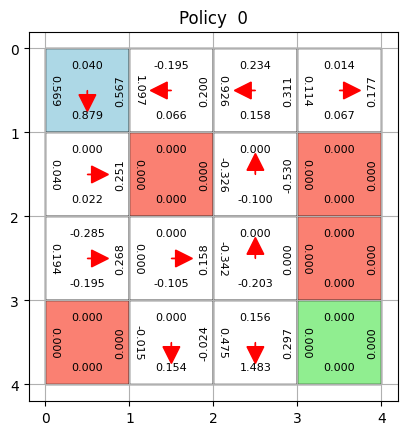

Updated policy 50 [0 1 3 0 1 0 2 0 0 2 1 0 0 2 3 0] 
 [[0 1 3 0]
 [1 0 2 0]
 [0 2 1 0]
 [0 2 3 0]]


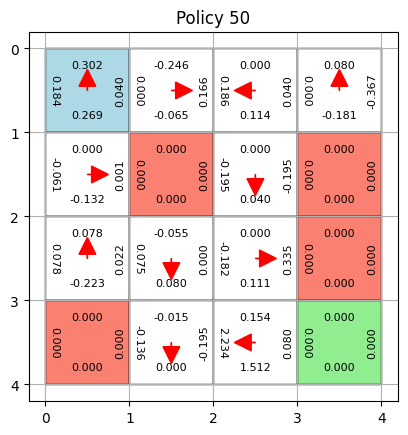

Updated policy 100 [3 3 0 3 1 0 0 0 3 1 1 0 0 2 1 0] 
 [[3 3 0 3]
 [1 0 0 0]
 [3 1 1 0]
 [0 2 1 0]]


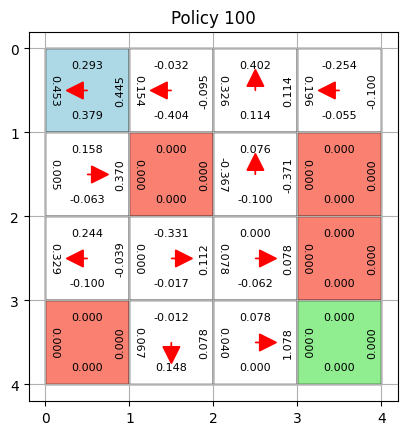

Updated policy 150 [0 2 1 3 0 0 0 0 3 0 0 0 0 1 2 0] 
 [[0 2 1 3]
 [0 0 0 0]
 [3 0 0 0]
 [0 1 2 0]]


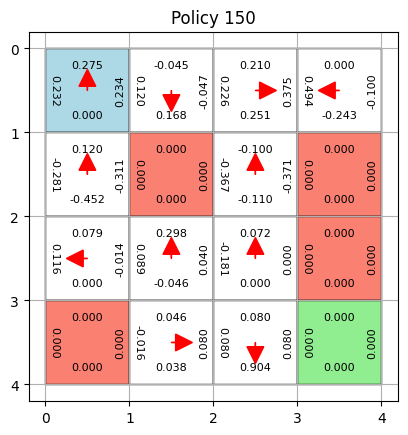

Updated policy 200 [3 3 3 2 0 0 0 0 1 1 1 0 0 2 3 0] 
 [[3 3 3 2]
 [0 0 0 0]
 [1 1 1 0]
 [0 2 3 0]]


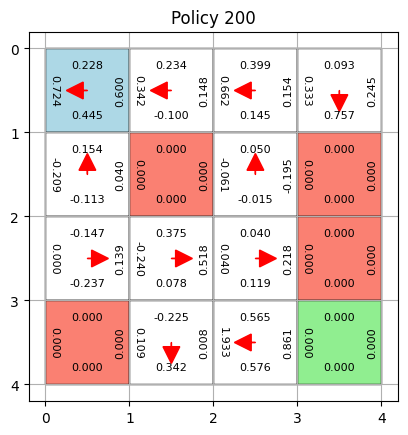

Current epsilon value - 0.855
Updated policy 250 [1 3 2 3 0 0 3 0 3 1 0 0 0 3 3 0] 
 [[1 3 2 3]
 [0 0 3 0]
 [3 1 0 0]
 [0 3 3 0]]


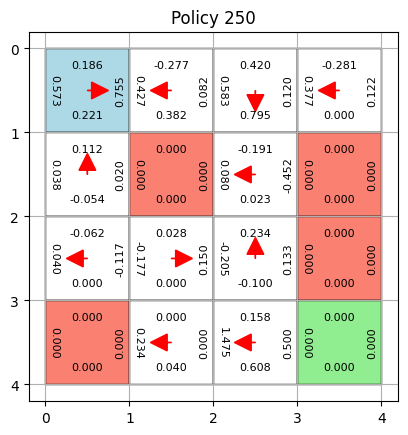

Updated policy 300 [2 2 0 3 1 0 2 0 3 1 0 0 0 1 1 0] 
 [[2 2 0 3]
 [1 0 2 0]
 [3 1 0 0]
 [0 1 1 0]]


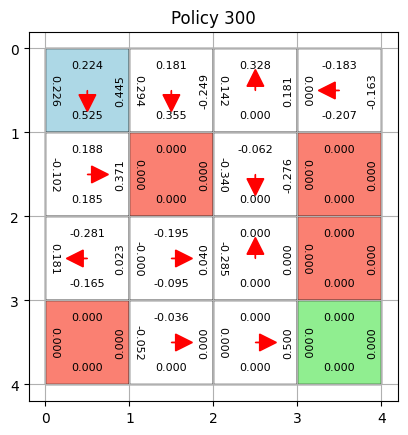

Updated policy 350 [1 3 1 3 2 0 2 0 2 0 1 0 0 3 3 0] 
 [[1 3 1 3]
 [2 0 2 0]
 [2 0 1 0]
 [0 3 3 0]]


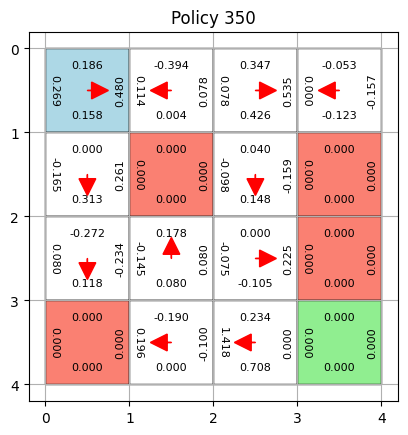

Updated policy 400 [3 3 0 2 2 0 0 0 3 1 0 0 0 2 2 0] 
 [[3 3 0 2]
 [2 0 0 0]
 [3 1 0 0]
 [0 2 2 0]]


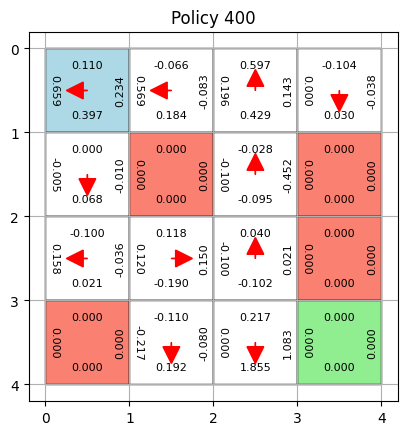

Updated policy 450 [0 3 0 1 0 0 0 0 1 1 2 0 0 1 2 0] 
 [[0 3 0 1]
 [0 0 0 0]
 [1 1 2 0]
 [0 1 2 0]]


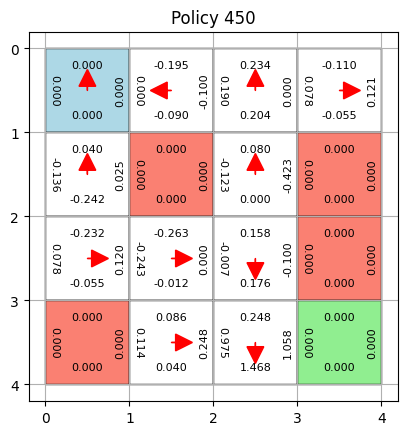

Current epsilon value - 0.8122499999999999
Updated policy 500 [2 1 0 0 2 0 2 0 3 1 0 0 0 2 1 0] 
 [[2 1 0 0]
 [2 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


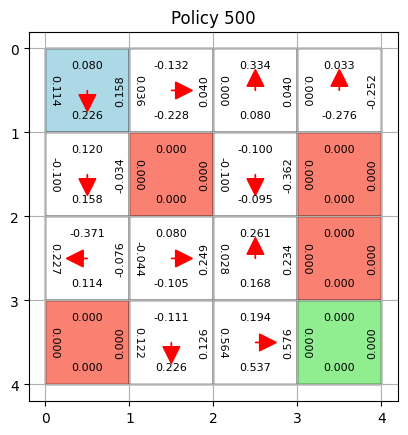

Updated policy 550 [1 2 3 2 0 0 2 0 3 1 1 0 0 2 3 0] 
 [[1 2 3 2]
 [0 0 2 0]
 [3 1 1 0]
 [0 2 3 0]]


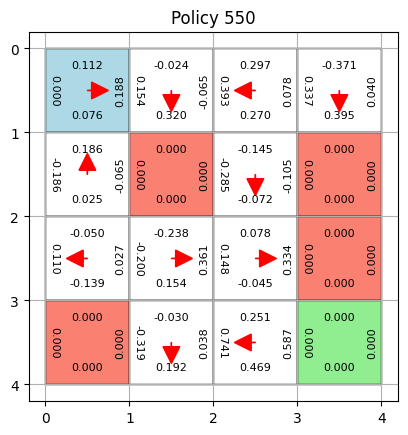

Updated policy 600 [2 1 2 3 3 0 1 0 1 1 0 0 0 0 1 0] 
 [[2 1 2 3]
 [3 0 1 0]
 [1 1 0 0]
 [0 0 1 0]]


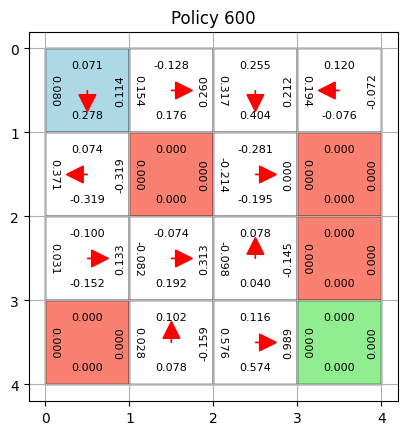

Updated policy 650 [1 2 1 3 2 0 2 0 3 1 0 0 0 2 3 0] 
 [[1 2 1 3]
 [2 0 2 0]
 [3 1 0 0]
 [0 2 3 0]]


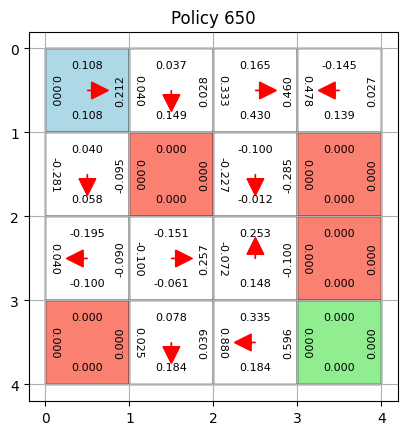

Updated policy 700 [2 3 0 1 1 0 0 0 1 3 1 0 0 2 1 0] 
 [[2 3 0 1]
 [1 0 0 0]
 [1 3 1 0]
 [0 2 1 0]]


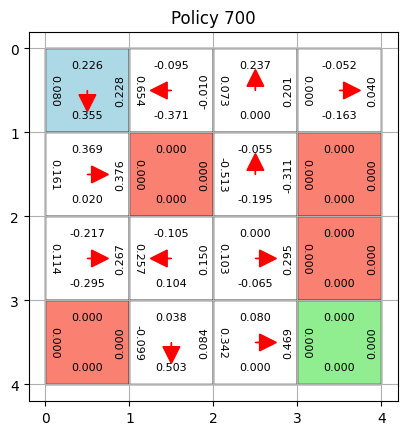

Current epsilon value - 0.7716374999999999
Updated policy 750 [0 3 0 1 0 0 3 0 2 1 1 0 0 2 3 0] 
 [[0 3 0 1]
 [0 0 3 0]
 [2 1 1 0]
 [0 2 3 0]]


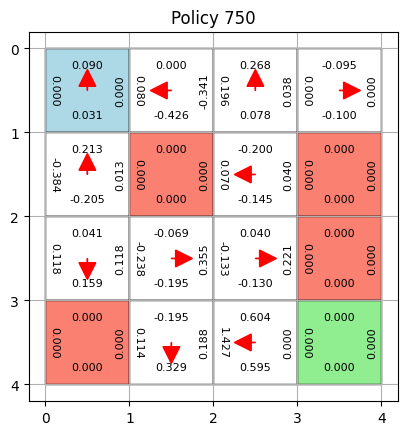

Updated policy 800 [0 1 2 3 0 0 0 0 0 1 2 0 0 3 2 0] 
 [[0 1 2 3]
 [0 0 0 0]
 [0 1 2 0]
 [0 3 2 0]]


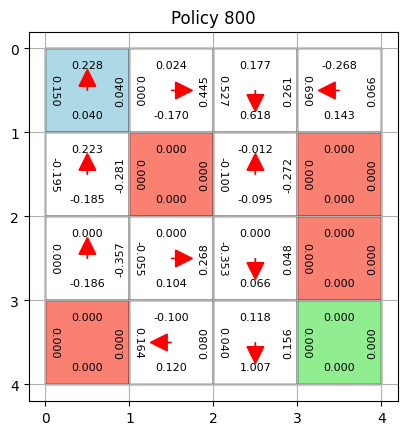

Updated policy 850 [3 3 3 0 0 0 1 0 0 1 0 0 0 2 2 0] 
 [[3 3 3 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 2 2 0]]


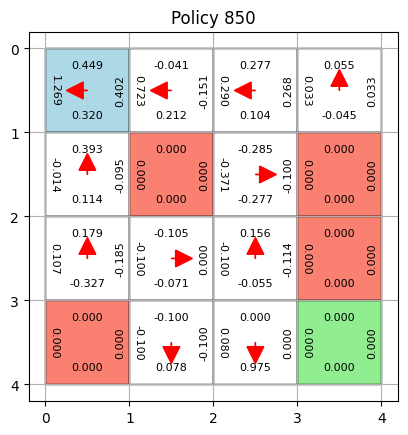

Updated policy 900 [1 3 0 2 0 0 0 0 1 0 0 0 0 2 1 0] 
 [[1 3 0 2]
 [0 0 0 0]
 [1 0 0 0]
 [0 2 1 0]]


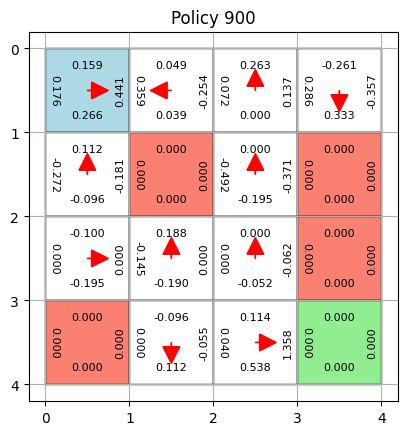

Updated policy 950 [2 3 0 0 0 0 2 0 3 1 0 0 0 0 3 0] 
 [[2 3 0 0]
 [0 0 2 0]
 [3 1 0 0]
 [0 0 3 0]]


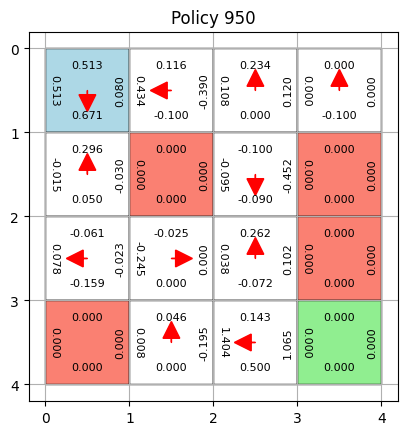

Current epsilon value - 0.7330556249999999
Updated policy 1000 [1 1 3 0 0 0 0 0 0 1 0 0 0 1 2 0] 
 [[1 1 3 0]
 [0 0 0 0]
 [0 1 0 0]
 [0 1 2 0]]


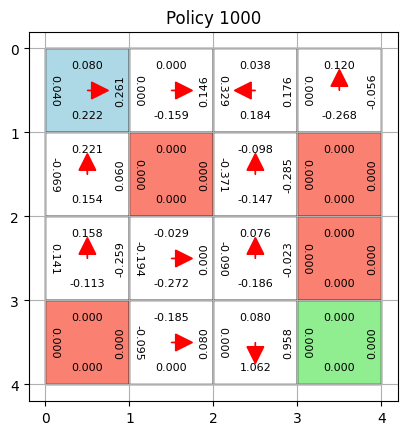

Updated policy 1050 [0 1 1 3 0 0 3 0 3 1 0 0 0 1 3 0] 
 [[0 1 1 3]
 [0 0 3 0]
 [3 1 0 0]
 [0 1 3 0]]


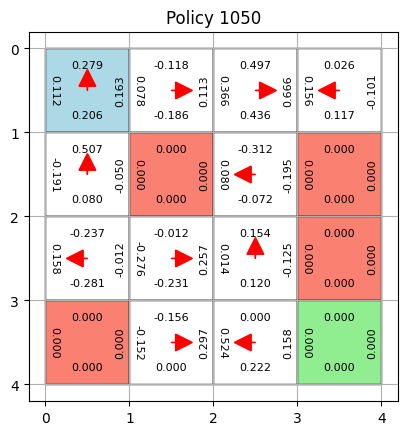

Updated policy 1100 [2 2 0 0 0 0 2 0 3 0 0 0 0 2 1 0] 
 [[2 2 0 0]
 [0 0 2 0]
 [3 0 0 0]
 [0 2 1 0]]


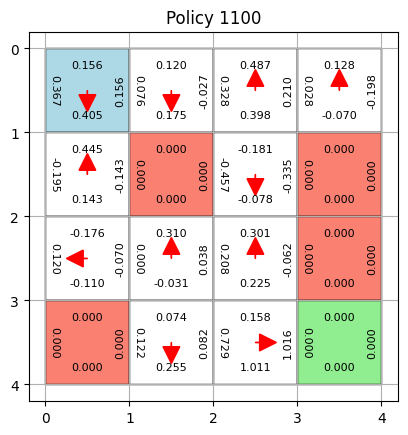

Updated policy 1150 [3 3 1 3 0 0 2 0 0 1 0 0 0 2 1 0] 
 [[3 3 1 3]
 [0 0 2 0]
 [0 1 0 0]
 [0 2 1 0]]


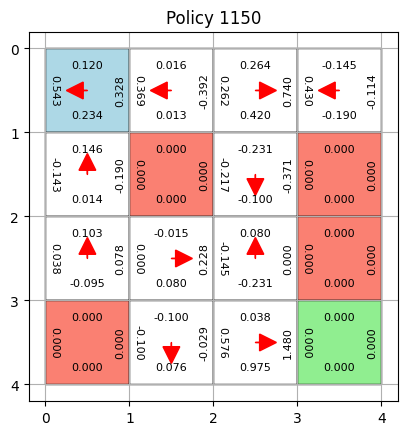

Updated policy 1200 [2 0 1 3 0 0 0 0 3 2 0 0 0 2 1 0] 
 [[2 0 1 3]
 [0 0 0 0]
 [3 2 0 0]
 [0 2 1 0]]


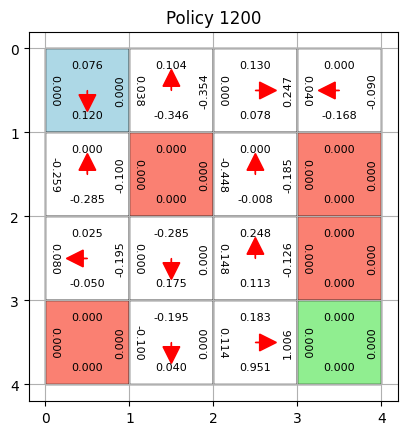

Current epsilon value - 0.6964028437499998
Updated policy 1250 [0 0 1 3 0 0 0 0 2 1 0 0 0 2 3 0] 
 [[0 0 1 3]
 [0 0 0 0]
 [2 1 0 0]
 [0 2 3 0]]


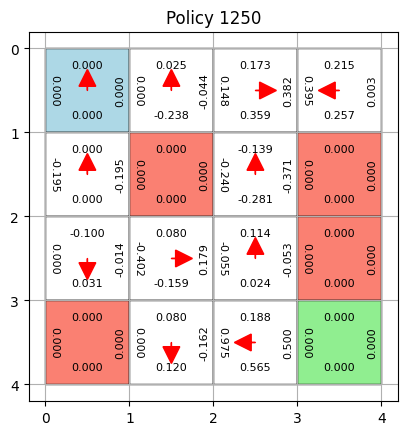

Updated policy 1300 [1 3 1 1 0 0 2 0 1 0 2 0 0 2 3 0] 
 [[1 3 1 1]
 [0 0 2 0]
 [1 0 2 0]
 [0 2 3 0]]


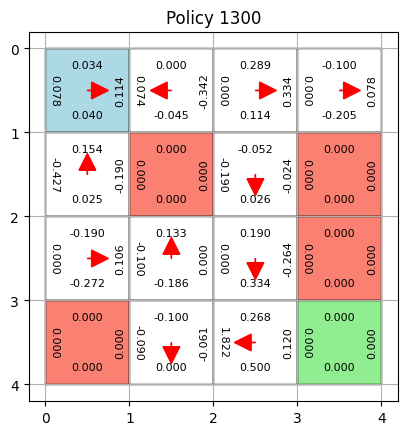

Updated policy 1350 [3 0 0 3 0 0 2 0 1 1 2 0 0 0 2 0] 
 [[3 0 0 3]
 [0 0 2 0]
 [1 1 2 0]
 [0 0 2 0]]


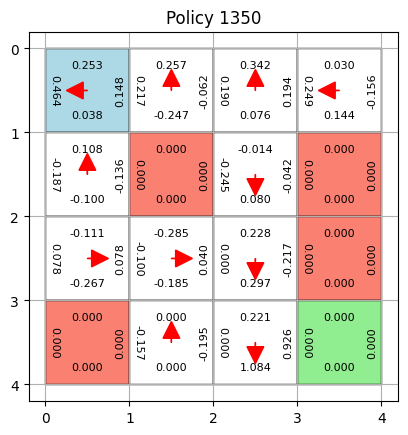

Updated policy 1400 [2 3 2 3 0 0 3 0 1 1 0 0 0 2 3 0] 
 [[2 3 2 3]
 [0 0 3 0]
 [1 1 0 0]
 [0 2 3 0]]


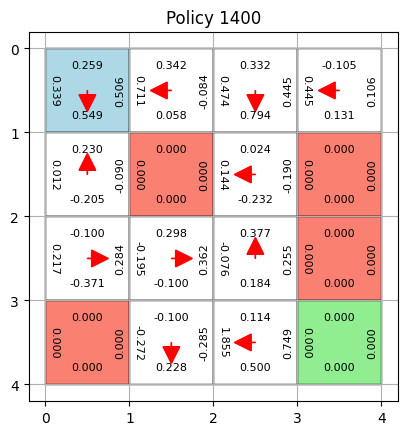

Updated policy 1450 [0 3 3 0 0 0 0 0 3 3 1 0 0 1 3 0] 
 [[0 3 3 0]
 [0 0 0 0]
 [3 3 1 0]
 [0 1 3 0]]


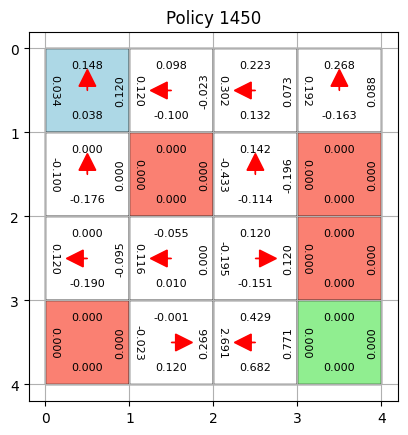

Current epsilon value - 0.6615827015624998
Updated policy 1500 [3 3 1 3 0 0 1 0 0 1 0 0 0 2 2 0] 
 [[3 3 1 3]
 [0 0 1 0]
 [0 1 0 0]
 [0 2 2 0]]


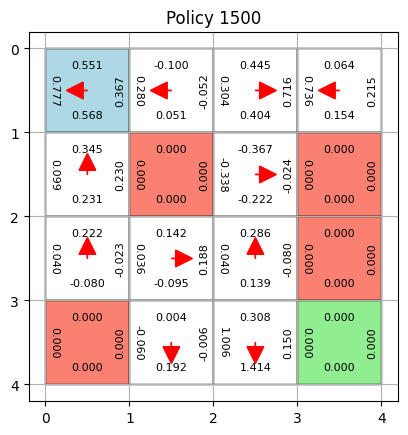

Updated policy 1550 [2 3 3 3 0 0 0 0 1 1 0 0 0 2 2 0] 
 [[2 3 3 3]
 [0 0 0 0]
 [1 1 0 0]
 [0 2 2 0]]


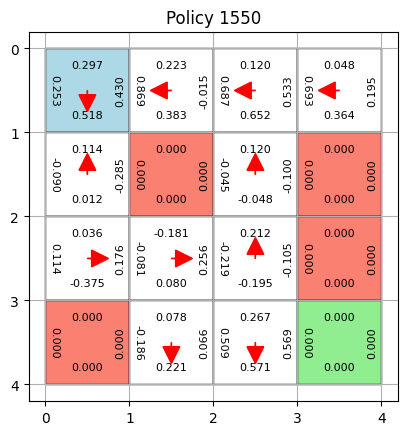

Updated policy 1600 [3 3 2 1 0 0 2 0 1 1 0 0 0 2 2 0] 
 [[3 3 2 1]
 [0 0 2 0]
 [1 1 0 0]
 [0 2 2 0]]


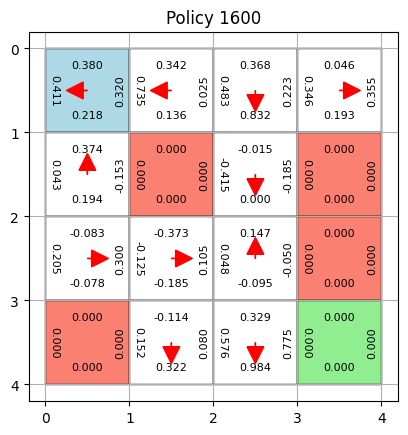

Updated policy 1650 [3 3 1 0 0 0 0 0 1 1 0 0 0 2 1 0] 
 [[3 3 1 0]
 [0 0 0 0]
 [1 1 0 0]
 [0 2 1 0]]


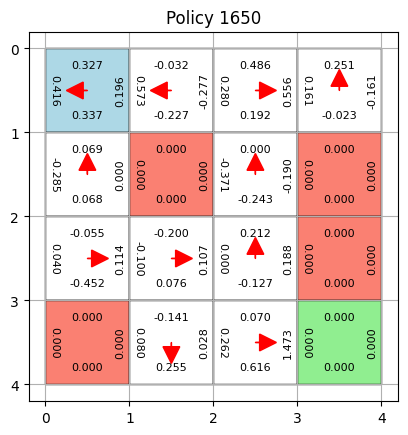

Updated policy 1700 [3 3 3 3 0 0 2 0 1 2 0 0 0 2 3 0] 
 [[3 3 3 3]
 [0 0 2 0]
 [1 2 0 0]
 [0 2 3 0]]


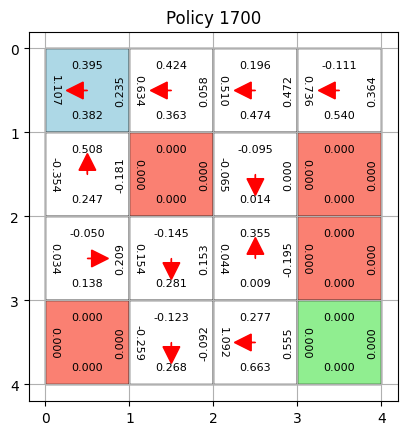

Current epsilon value - 0.6285035664843748
Updated policy 1750 [3 3 1 3 1 0 0 0 3 3 0 0 0 0 1 0] 
 [[3 3 1 3]
 [1 0 0 0]
 [3 3 0 0]
 [0 0 1 0]]


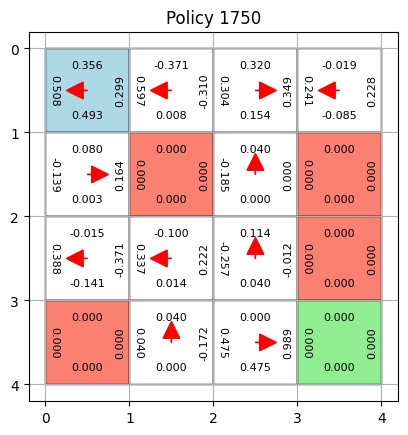

Updated policy 1800 [3 3 3 3 0 0 0 0 0 0 0 0 0 0 2 0] 
 [[3 3 3 3]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 2 0]]


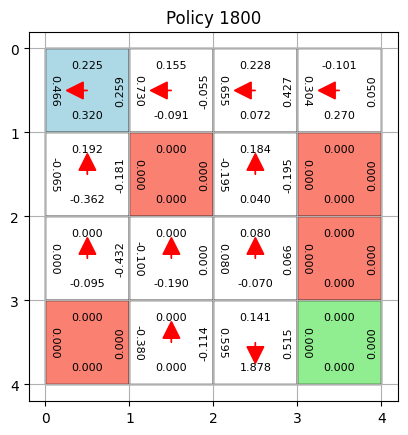

Updated policy 1850 [1 3 3 0 0 0 2 0 3 1 0 0 0 1 2 0] 
 [[1 3 3 0]
 [0 0 2 0]
 [3 1 0 0]
 [0 1 2 0]]


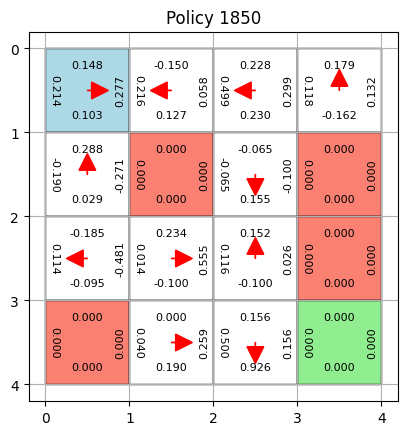

Updated policy 1900 [3 0 1 0 0 0 2 0 3 1 0 0 0 2 2 0] 
 [[3 0 1 0]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 2 0]]


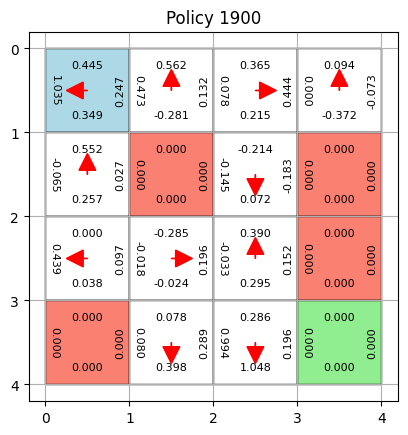

Updated policy 1950 [3 3 3 3 0 0 0 0 3 1 3 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 0 0]
 [3 1 3 0]
 [0 2 1 0]]


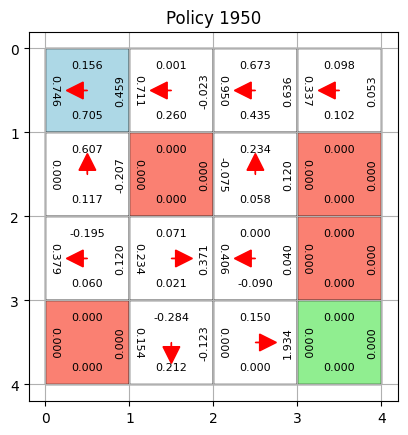

Current epsilon value - 0.597078388160156
Updated policy 2000 [3 3 1 0 0 0 0 0 3 1 0 0 0 2 2 0] 
 [[3 3 1 0]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 2 0]]


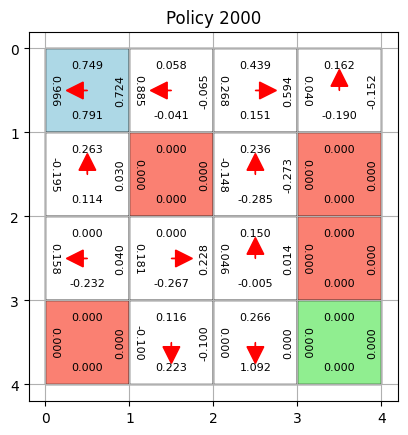

Updated policy 2050 [3 3 3 3 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


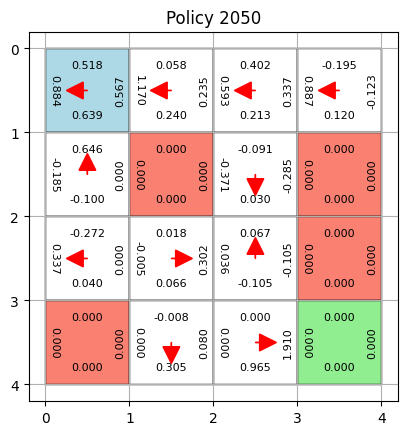

Updated policy 2100 [3 3 2 3 0 0 1 0 3 1 0 0 0 2 1 0] 
 [[3 3 2 3]
 [0 0 1 0]
 [3 1 0 0]
 [0 2 1 0]]


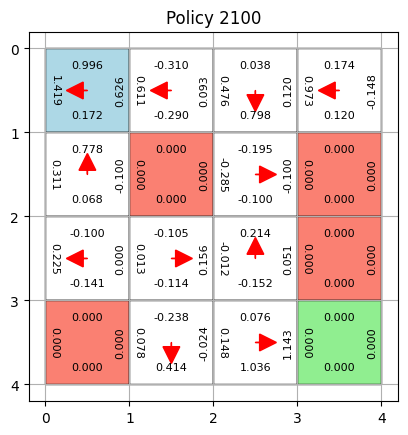

Updated policy 2150 [3 3 1 3 0 0 0 0 0 1 0 0 0 2 3 0] 
 [[3 3 1 3]
 [0 0 0 0]
 [0 1 0 0]
 [0 2 3 0]]


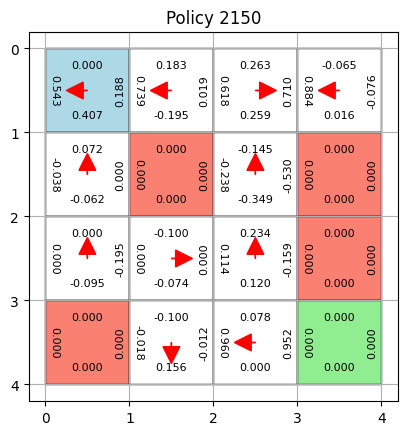

Updated policy 2200 [3 3 3 0 0 0 0 0 3 1 1 0 0 2 3 0] 
 [[3 3 3 0]
 [0 0 0 0]
 [3 1 1 0]
 [0 2 3 0]]


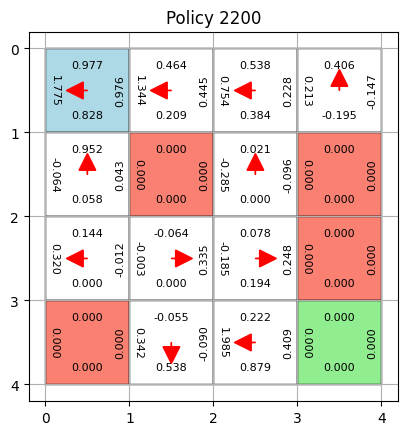

Current epsilon value - 0.5672244687521482
Updated policy 2250 [3 0 3 3 0 0 3 0 3 1 0 0 0 2 3 0] 
 [[3 0 3 3]
 [0 0 3 0]
 [3 1 0 0]
 [0 2 3 0]]


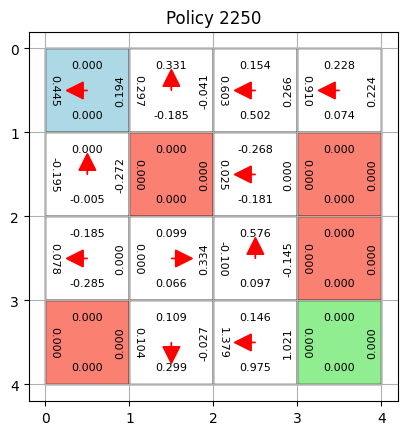

Updated policy 2300 [1 3 1 3 0 0 0 0 3 1 1 0 0 2 2 0] 
 [[1 3 1 3]
 [0 0 0 0]
 [3 1 1 0]
 [0 2 2 0]]


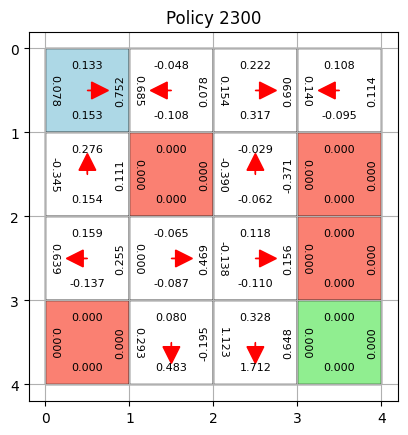

Updated policy 2350 [1 3 1 3 0 0 0 0 1 1 0 0 0 2 3 0] 
 [[1 3 1 3]
 [0 0 0 0]
 [1 1 0 0]
 [0 2 3 0]]


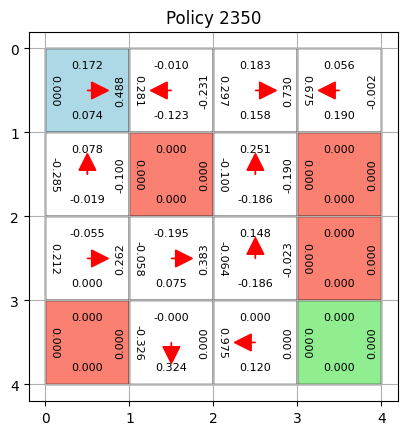

Updated policy 2400 [3 0 0 0 0 0 0 0 3 1 0 0 0 2 1 0] 
 [[3 0 0 0]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


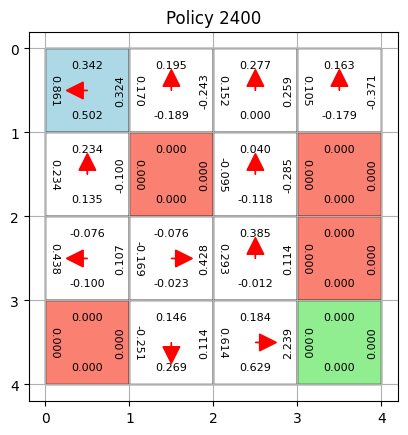

Updated policy 2450 [2 3 1 3 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[2 3 1 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


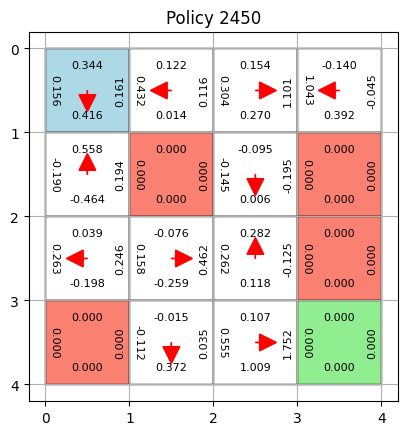

Current epsilon value - 0.5388632453145408
Updated policy 2500 [3 3 3 3 0 0 2 0 0 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 2 0]
 [0 1 0 0]
 [0 2 1 0]]


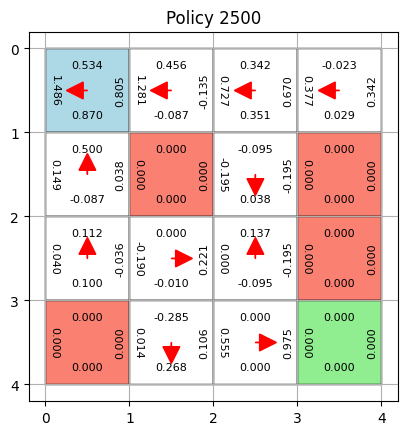

Updated policy 2550 [3 3 0 3 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[3 3 0 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


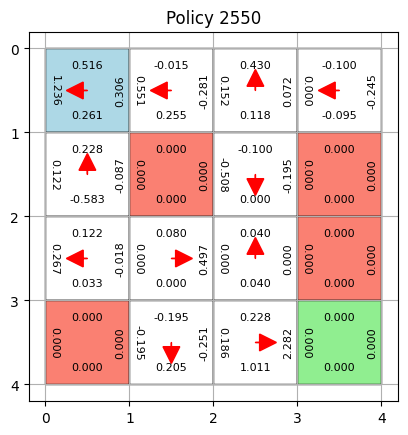

Updated policy 2600 [0 3 1 3 0 0 2 0 3 1 0 0 0 2 2 0] 
 [[0 3 1 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 2 0]]


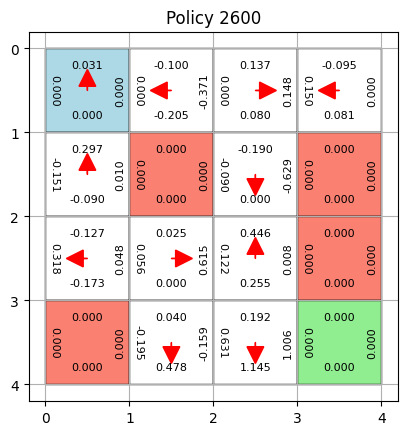

Updated policy 2650 [3 3 1 3 3 0 0 0 3 1 0 0 0 2 1 0] 
 [[3 3 1 3]
 [3 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


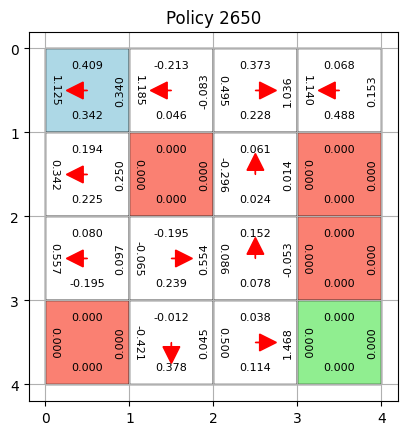

Updated policy 2700 [3 3 2 3 1 0 2 0 3 1 0 0 0 1 1 0] 
 [[3 3 2 3]
 [1 0 2 0]
 [3 1 0 0]
 [0 1 1 0]]


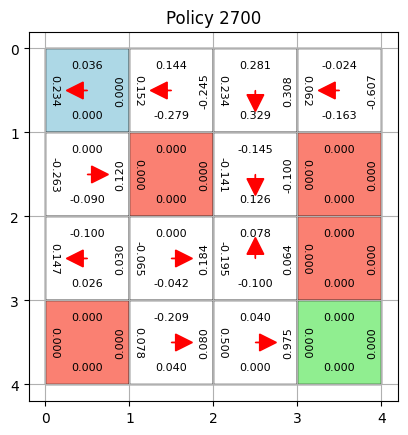

Current epsilon value - 0.5119200830488138
Updated policy 2750 [3 3 0 3 0 0 0 0 1 1 0 0 0 3 3 0] 
 [[3 3 0 3]
 [0 0 0 0]
 [1 1 0 0]
 [0 3 3 0]]


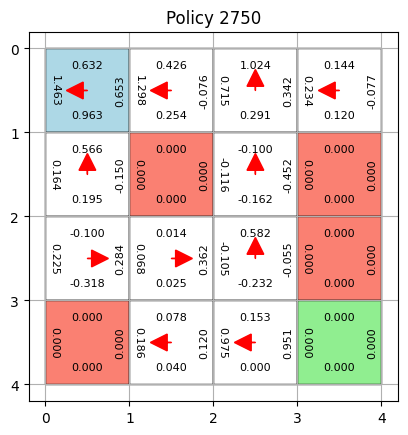

Updated policy 2800 [1 3 1 3 0 0 0 0 3 1 0 0 0 2 3 0] 
 [[1 3 1 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 3 0]]


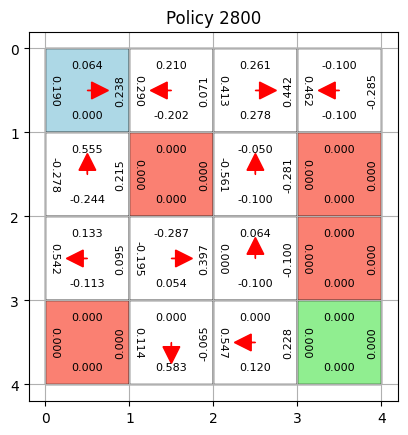

Updated policy 2850 [3 3 1 3 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[3 3 1 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


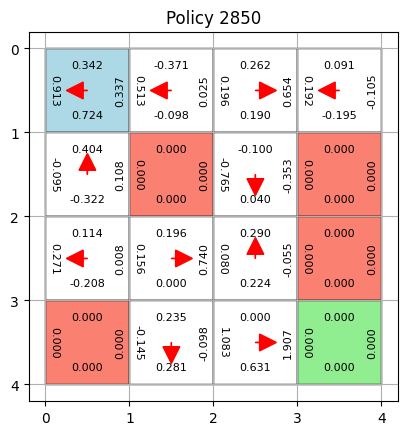

Updated policy 2900 [3 3 3 3 0 0 3 0 0 1 0 0 0 2 2 0] 
 [[3 3 3 3]
 [0 0 3 0]
 [0 1 0 0]
 [0 2 2 0]]


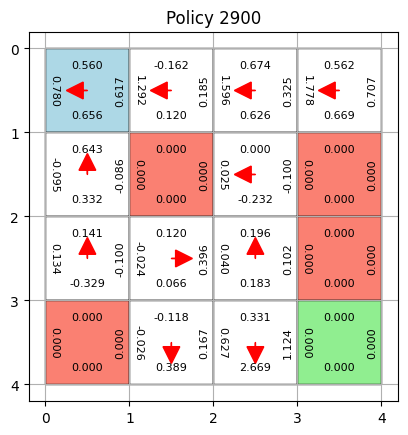

Updated policy 2950 [1 3 2 3 0 0 3 0 1 1 0 0 0 2 3 0] 
 [[1 3 2 3]
 [0 0 3 0]
 [1 1 0 0]
 [0 2 3 0]]


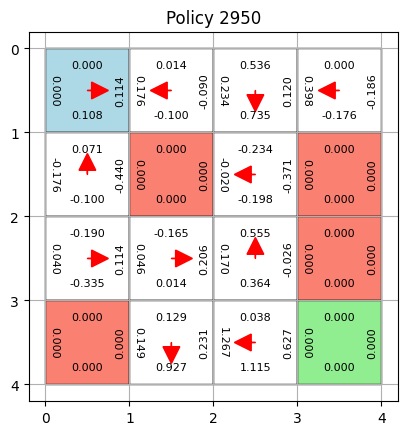

Current epsilon value - 0.486324078896373
Updated policy 3000 [3 3 0 3 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[3 3 0 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


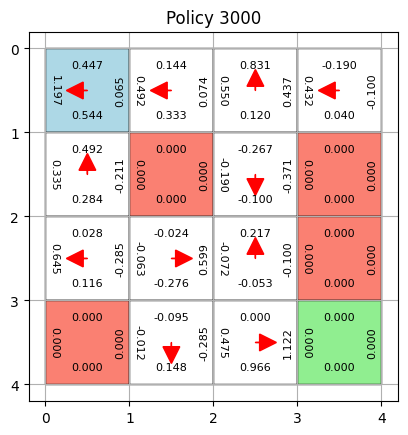

Updated policy 3050 [3 3 3 1 0 0 3 0 3 2 0 0 0 0 2 0] 
 [[3 3 3 1]
 [0 0 3 0]
 [3 2 0 0]
 [0 0 2 0]]


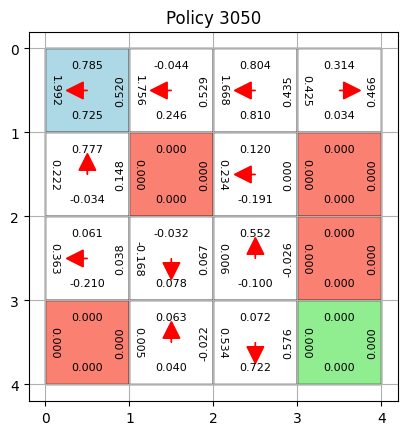

Updated policy 3100 [2 0 0 0 0 0 1 0 0 1 0 0 0 2 3 0] 
 [[2 0 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 2 3 0]]


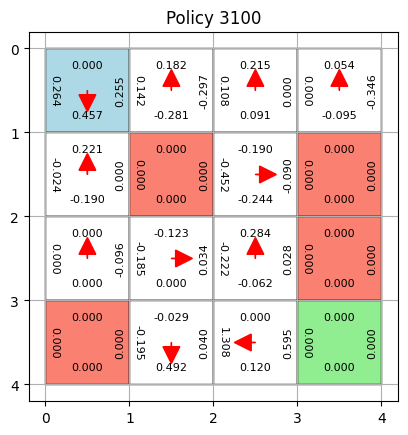

Updated policy 3150 [3 3 1 3 0 0 3 0 3 1 0 0 0 2 1 0] 
 [[3 3 1 3]
 [0 0 3 0]
 [3 1 0 0]
 [0 2 1 0]]


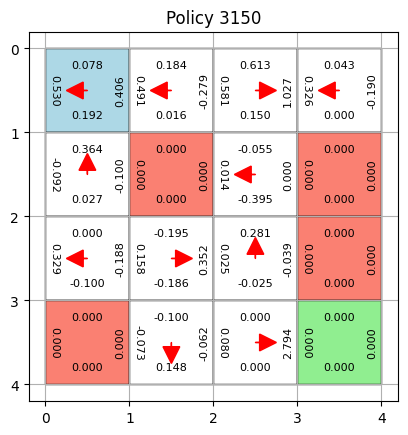

Updated policy 3200 [3 3 3 3 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


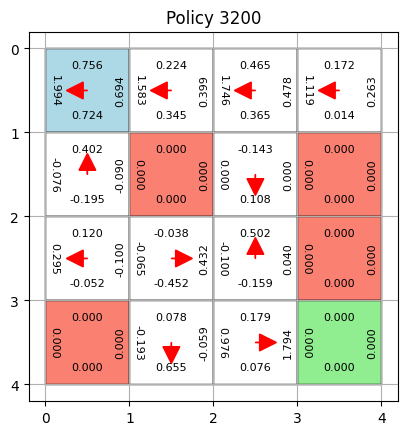

Current epsilon value - 0.4620078749515544
Updated policy 3250 [3 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


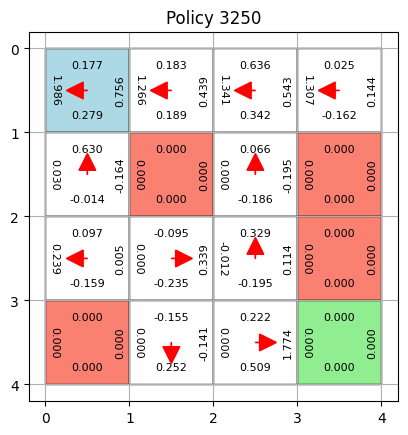

Updated policy 3300 [3 3 3 3 0 0 0 0 0 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 0 0]
 [0 1 0 0]
 [0 2 1 0]]


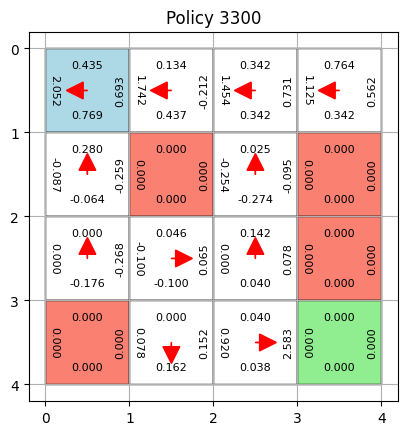

Updated policy 3350 [3 3 0 2 0 0 2 0 3 1 2 0 0 2 2 0] 
 [[3 3 0 2]
 [0 0 2 0]
 [3 1 2 0]
 [0 2 2 0]]


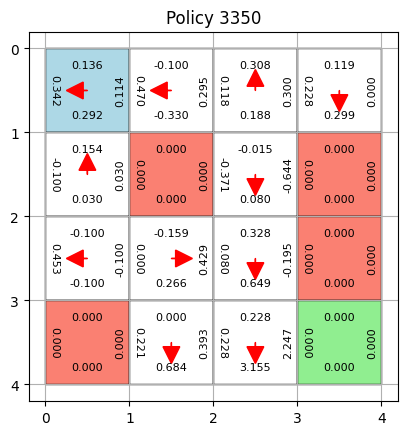

Updated policy 3400 [1 3 1 3 0 0 2 0 3 1 0 0 0 2 3 0] 
 [[1 3 1 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 3 0]]


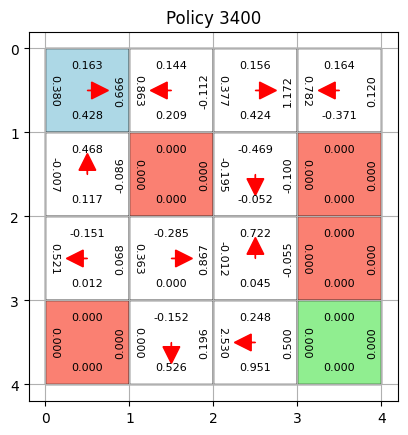

Updated policy 3450 [2 3 0 1 0 0 2 0 3 1 0 0 0 3 2 0] 
 [[2 3 0 1]
 [0 0 2 0]
 [3 1 0 0]
 [0 3 2 0]]


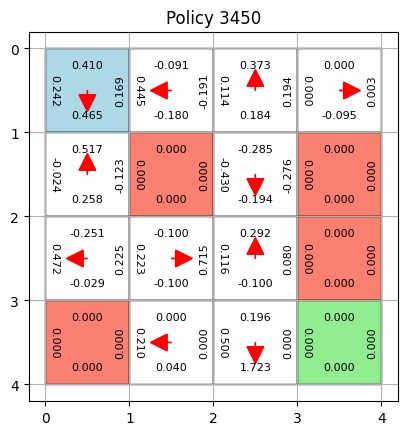

Current epsilon value - 0.43890748120397666
Updated policy 3500 [1 3 0 2 0 0 0 0 0 1 0 0 0 2 1 0] 
 [[1 3 0 2]
 [0 0 0 0]
 [0 1 0 0]
 [0 2 1 0]]


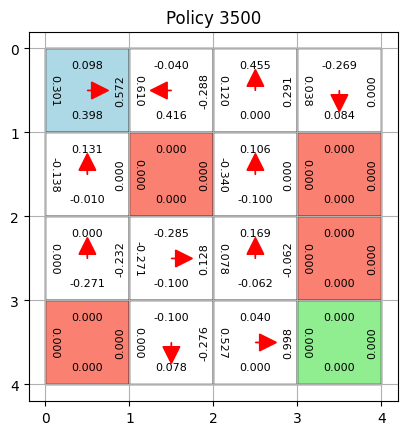

Updated policy 3550 [2 3 3 3 0 0 0 0 3 1 0 0 0 2 3 0] 
 [[2 3 3 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 3 0]]


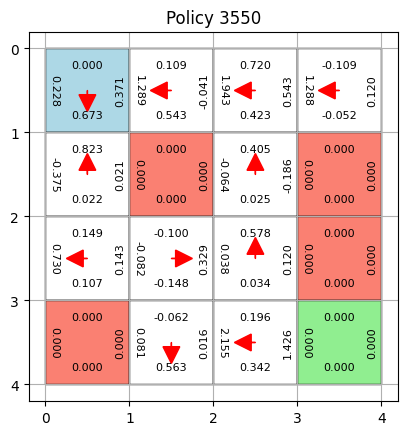

Updated policy 3600 [3 3 1 3 0 0 1 0 3 1 0 0 0 2 2 0] 
 [[3 3 1 3]
 [0 0 1 0]
 [3 1 0 0]
 [0 2 2 0]]


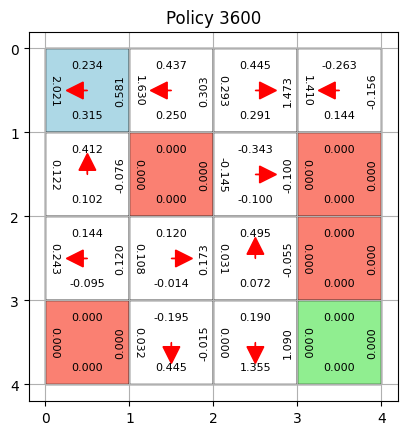

Updated policy 3650 [3 3 3 3 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


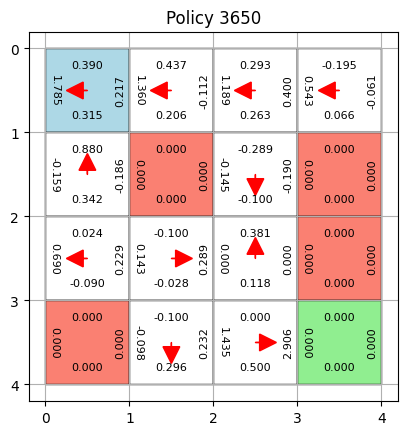

Updated policy 3700 [3 3 3 3 0 0 2 0 3 1 0 0 0 2 2 0] 
 [[3 3 3 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 2 0]]


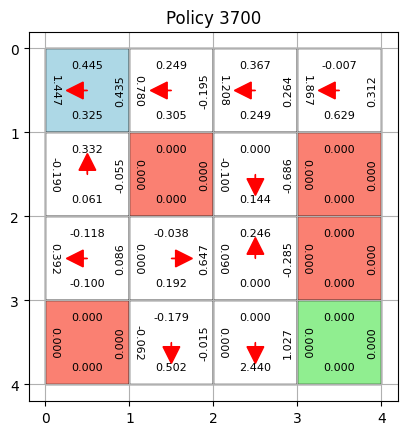

Current epsilon value - 0.4169621071437778
Updated policy 3750 [3 3 3 3 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


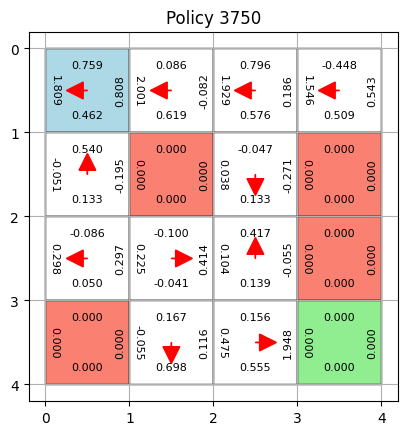

Updated policy 3800 [3 3 3 3 0 0 3 0 3 1 0 0 0 2 2 0] 
 [[3 3 3 3]
 [0 0 3 0]
 [3 1 0 0]
 [0 2 2 0]]


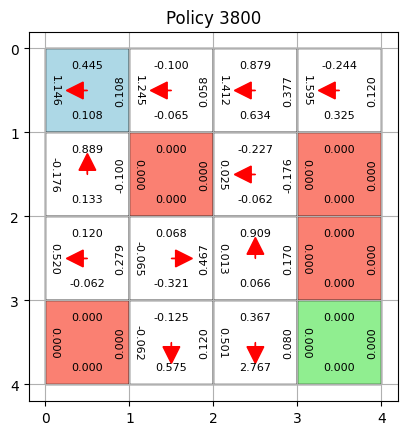

Updated policy 3850 [3 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


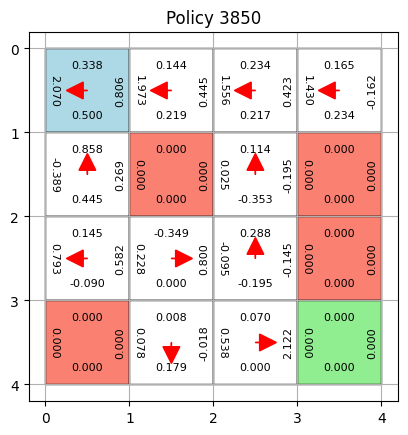

Updated policy 3900 [3 3 3 3 0 0 2 0 1 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 2 0]
 [1 1 0 0]
 [0 2 1 0]]


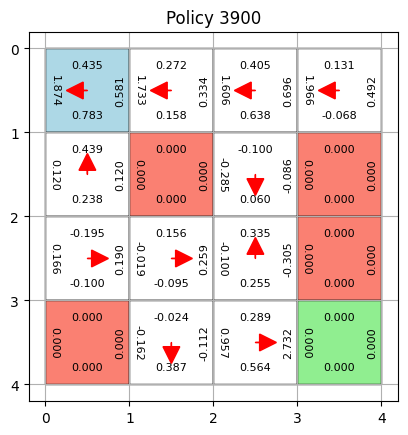

Updated policy 3950 [3 3 0 1 0 0 0 0 3 1 0 0 0 2 2 0] 
 [[3 3 0 1]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 2 0]]


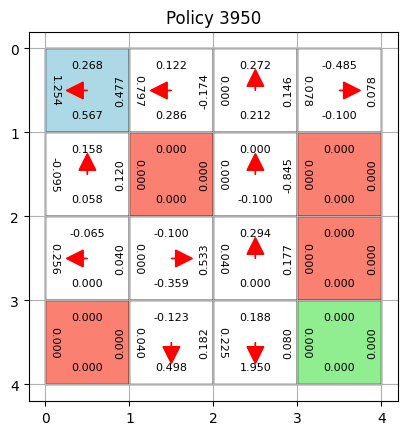

Current epsilon value - 0.3961140017865889
Updated policy 4000 [1 3 1 3 0 0 3 0 3 1 0 0 0 2 3 0] 
 [[1 3 1 3]
 [0 0 3 0]
 [3 1 0 0]
 [0 2 3 0]]


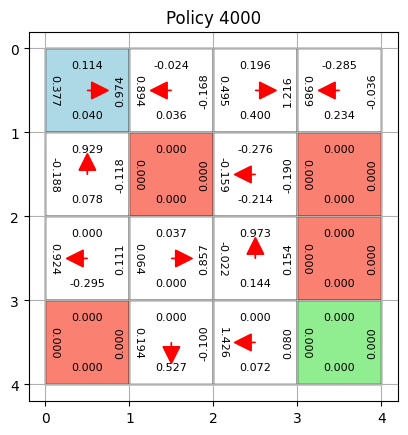

Updated policy 4050 [3 3 3 3 0 0 0 0 3 1 0 0 0 2 3 0] 
 [[3 3 3 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 3 0]]


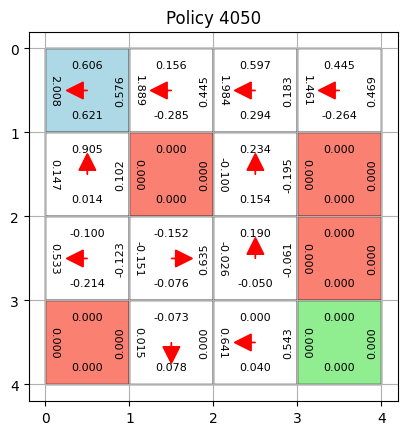

Updated policy 4100 [1 3 1 3 0 0 1 0 3 1 0 0 0 2 2 0] 
 [[1 3 1 3]
 [0 0 1 0]
 [3 1 0 0]
 [0 2 2 0]]


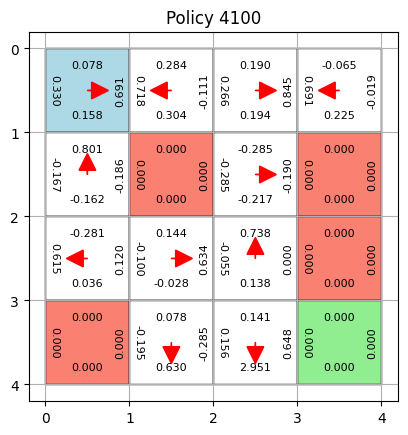

Updated policy 4150 [2 3 1 3 0 0 0 0 3 1 0 0 0 2 3 0] 
 [[2 3 1 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 3 0]]


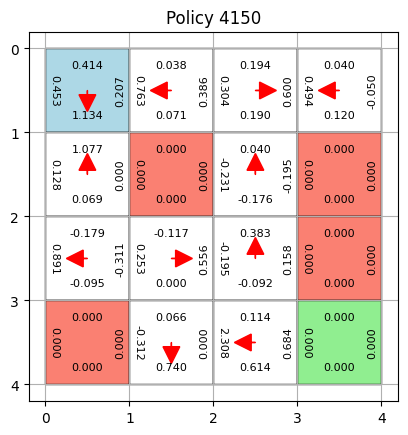

Updated policy 4200 [1 3 1 3 0 0 3 0 3 1 0 0 0 2 1 0] 
 [[1 3 1 3]
 [0 0 3 0]
 [3 1 0 0]
 [0 2 1 0]]


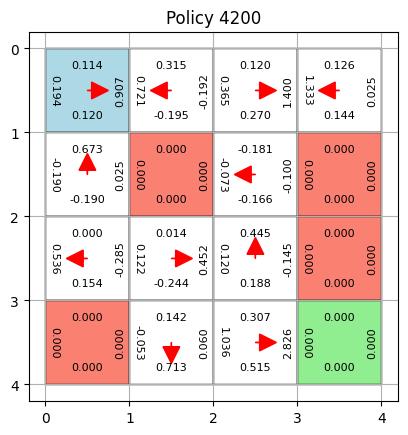

Current epsilon value - 0.37630830169725943
Updated policy 4250 [3 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


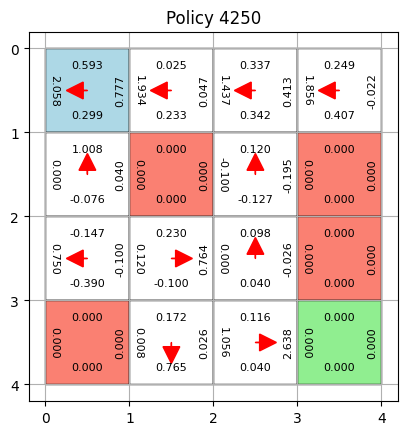

Updated policy 4300 [3 3 0 1 2 0 2 0 0 1 0 0 0 2 2 0] 
 [[3 3 0 1]
 [2 0 2 0]
 [0 1 0 0]
 [0 2 2 0]]


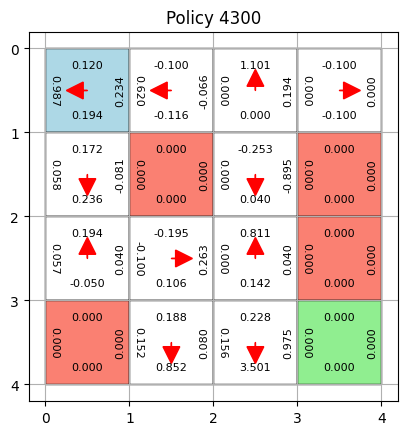

Updated policy 4350 [3 3 3 3 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


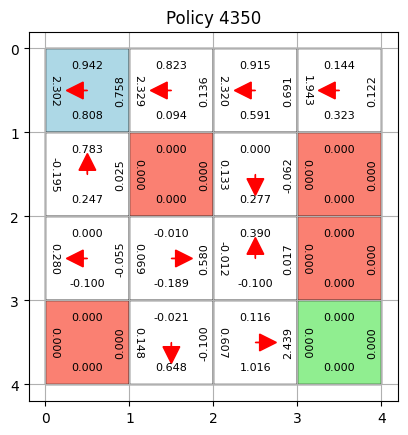

Updated policy 4400 [3 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


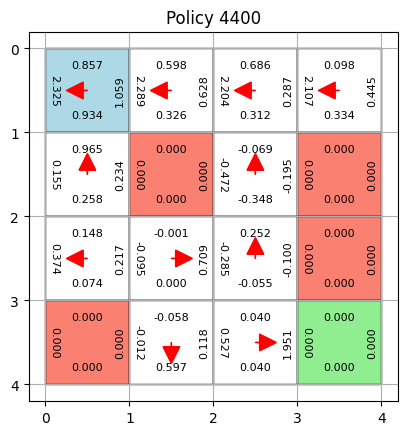

Updated policy 4450 [3 3 3 3 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


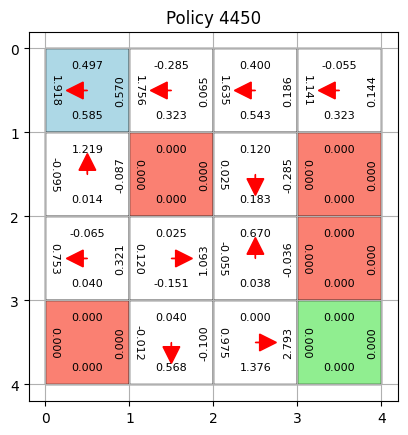

Current epsilon value - 0.3574928866123964
Updated policy 4500 [3 3 3 3 0 0 0 0 3 0 2 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 0 0]
 [3 0 2 0]
 [0 2 1 0]]


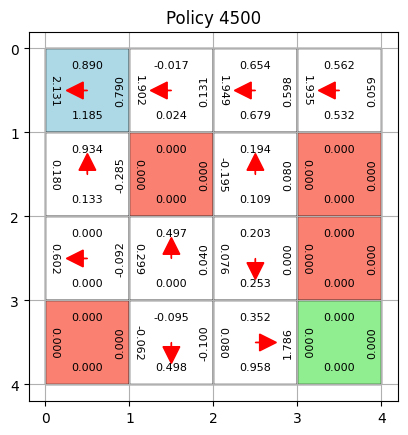

Updated policy 4550 [3 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


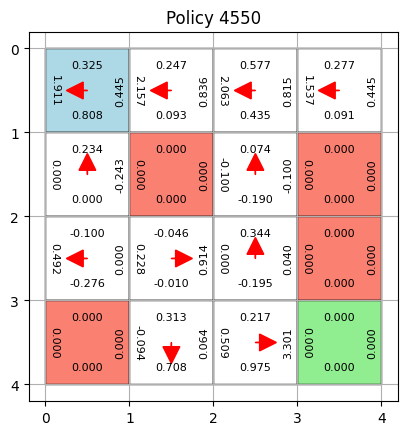

Updated policy 4600 [3 3 3 3 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


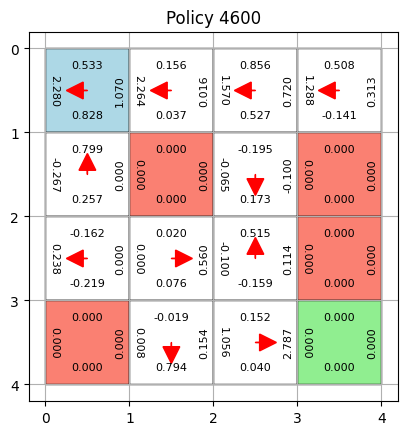

Updated policy 4650 [3 3 3 3 0 0 2 0 3 1 0 0 0 2 2 0] 
 [[3 3 3 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 2 0]]


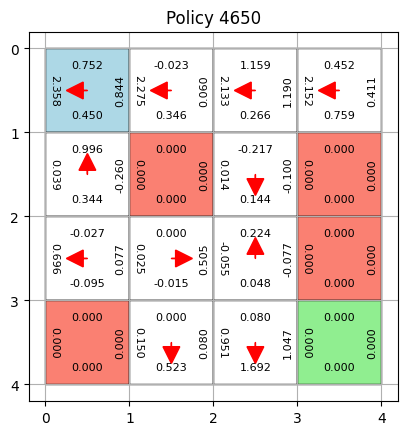

Updated policy 4700 [3 3 3 3 0 0 2 0 3 1 0 0 0 2 2 0] 
 [[3 3 3 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 2 0]]


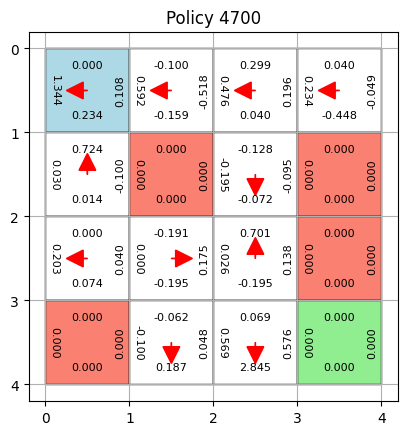

Current epsilon value - 0.33961824228177656
Updated policy 4750 [3 3 3 3 0 0 0 0 3 1 0 0 0 0 2 0] 
 [[3 3 3 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 0 2 0]]


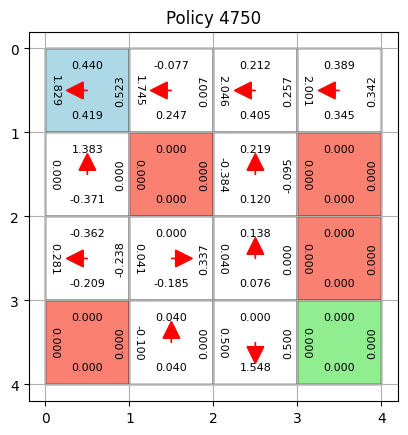

Updated policy 4800 [3 3 3 3 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


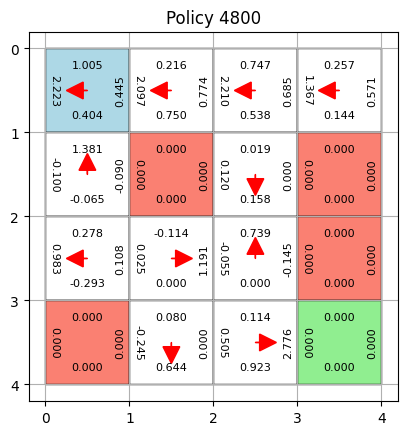

Updated policy 4850 [3 3 0 3 0 0 1 0 3 1 0 0 0 2 3 0] 
 [[3 3 0 3]
 [0 0 1 0]
 [3 1 0 0]
 [0 2 3 0]]


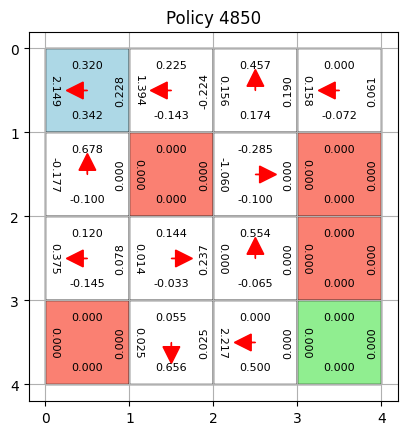

Updated policy 4900 [0 0 0 1 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[0 0 0 1]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


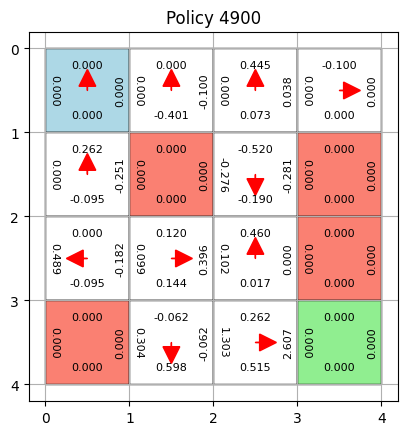

Updated policy 4950 [3 3 3 3 0 0 3 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 3 0]
 [3 1 0 0]
 [0 2 1 0]]


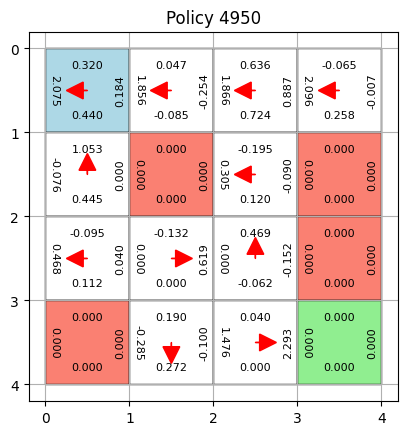

Current epsilon value - 0.3226373301676877
Updated policy 5000 [3 3 0 0 0 0 2 0 3 1 0 0 0 2 2 0] 
 [[3 3 0 0]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 2 0]]


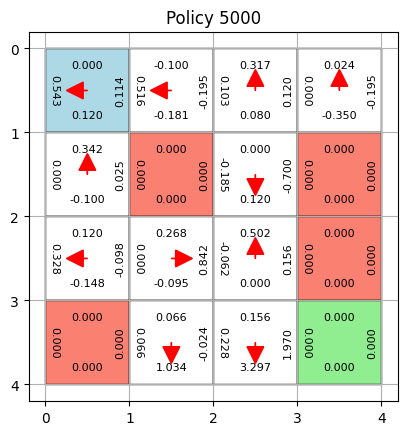

Updated policy 5050 [3 3 1 3 0 0 3 0 3 1 0 0 0 2 1 0] 
 [[3 3 1 3]
 [0 0 3 0]
 [3 1 0 0]
 [0 2 1 0]]


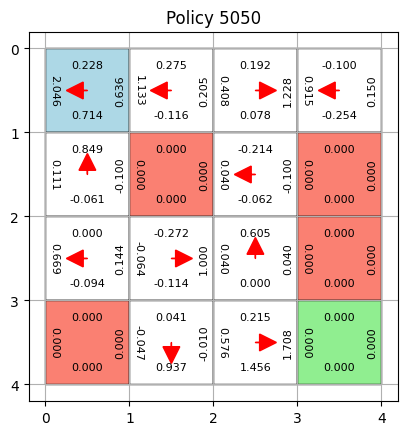

Updated policy 5100 [3 3 1 3 0 0 1 0 3 1 0 0 0 2 1 0] 
 [[3 3 1 3]
 [0 0 1 0]
 [3 1 0 0]
 [0 2 1 0]]


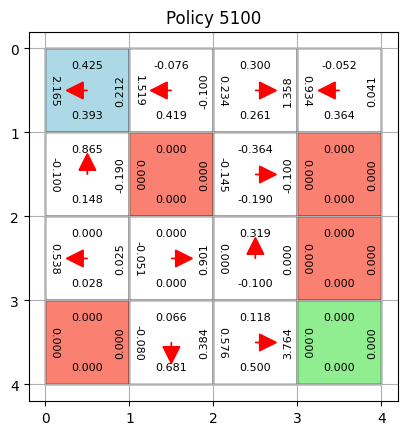

Updated policy 5150 [3 3 1 3 0 0 0 0 3 1 0 0 0 2 1 0] 
 [[3 3 1 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


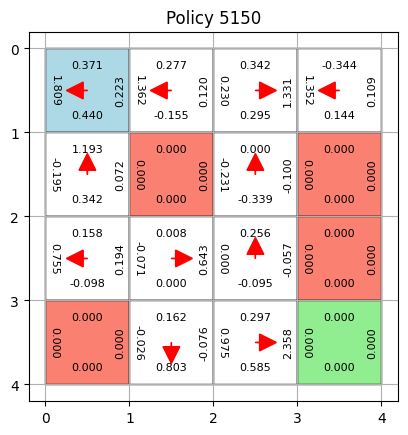

Updated policy 5200 [3 3 1 3 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[3 3 1 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


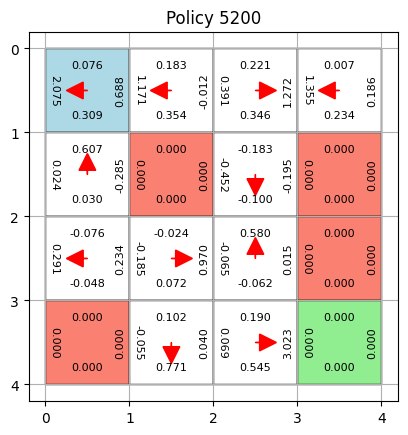

Current epsilon value - 0.3065054636593033
Updated policy 5250 [3 3 1 3 0 0 0 0 3 1 0 0 0 2 3 0] 
 [[3 3 1 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 3 0]]


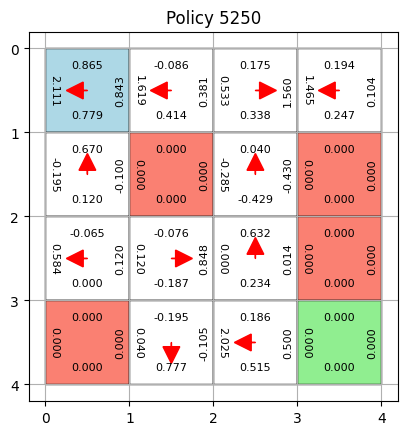

Updated policy 5300 [3 3 3 3 0 0 0 0 3 1 0 0 0 2 3 0] 
 [[3 3 3 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 3 0]]


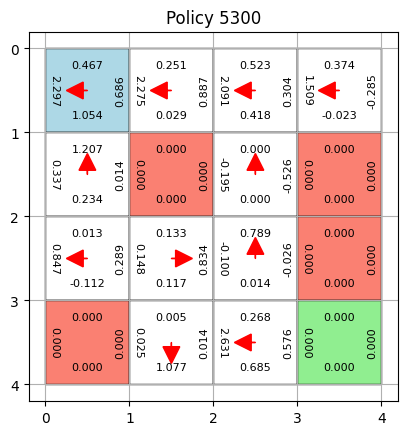

Updated policy 5350 [3 3 3 3 0 0 0 0 3 1 0 0 0 2 3 0] 
 [[3 3 3 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 3 0]]


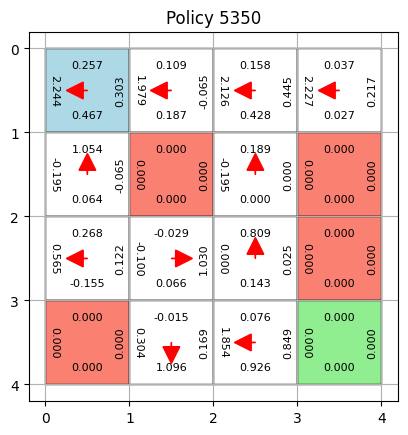

Updated policy 5400 [3 3 3 3 0 0 3 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 3 0]
 [3 1 0 0]
 [0 2 1 0]]


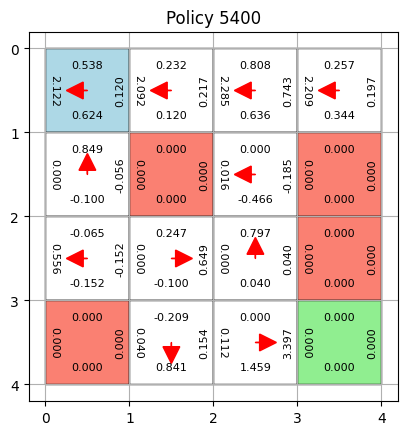

Updated policy 5450 [3 3 3 3 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


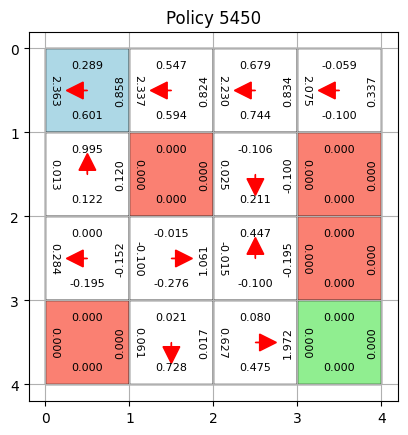

Current epsilon value - 0.29118019047633814
Updated policy 5500 [3 3 3 3 0 0 3 0 3 1 0 0 0 2 2 0] 
 [[3 3 3 3]
 [0 0 3 0]
 [3 1 0 0]
 [0 2 2 0]]


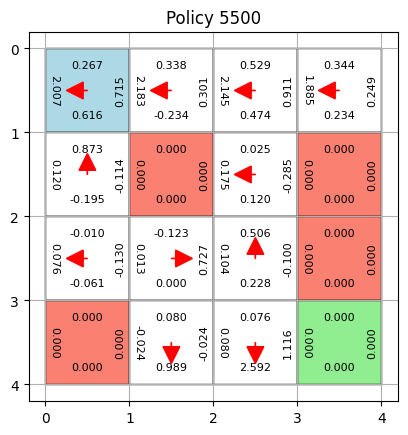

Updated policy 5550 [3 3 3 3 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


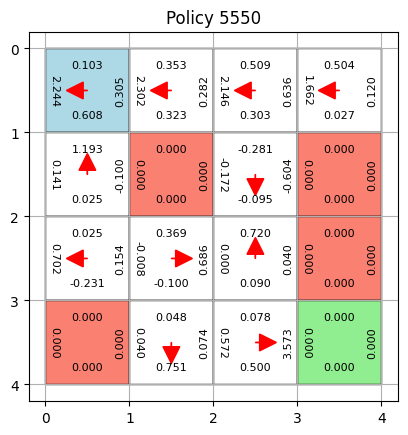

Updated policy 5600 [1 3 0 0 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[1 3 0 0]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


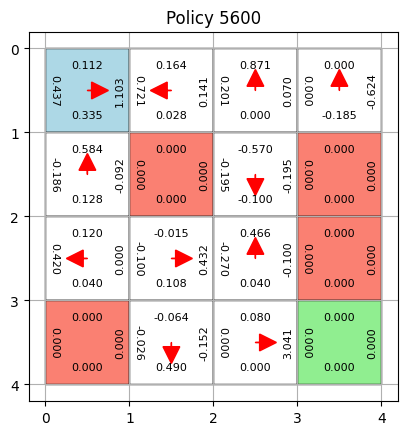

Updated policy 5650 [0 0 0 2 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[0 0 0 2]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


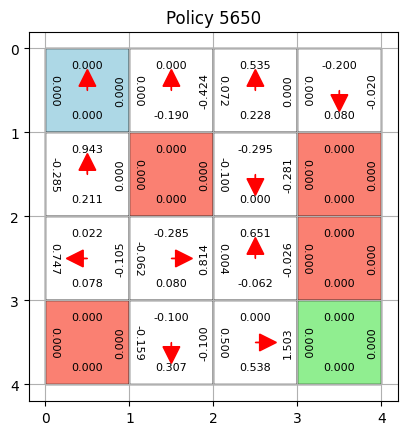

Updated policy 5700 [1 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0] 
 [[1 3 3 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


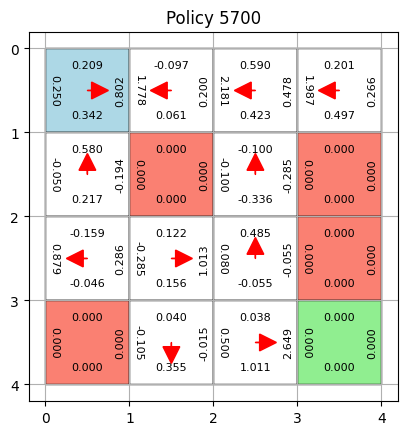

Current epsilon value - 0.2766211809525212
Updated policy 5750 [3 3 3 3 0 0 3 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 3 0]
 [3 1 0 0]
 [0 2 1 0]]


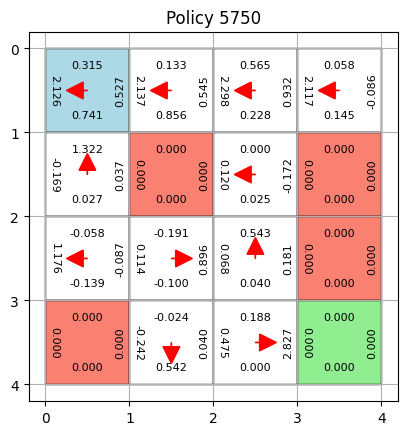

Updated policy 5800 [3 3 3 3 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


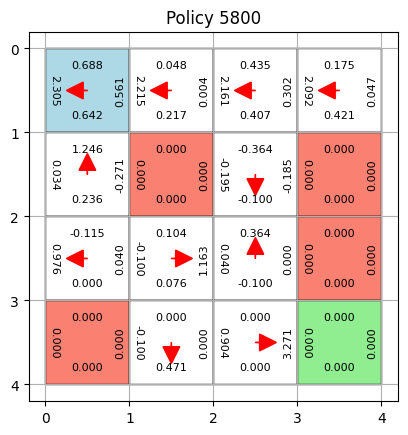

Updated policy 5850 [3 3 0 3 0 0 0 0 3 1 0 0 0 2 3 0] 
 [[3 3 0 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 3 0]]


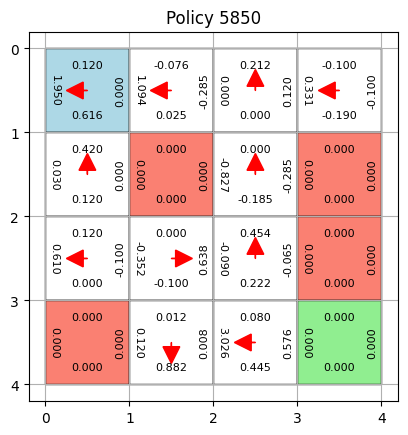

Updated policy 5900 [1 3 0 3 0 0 2 0 3 1 0 0 0 2 2 0] 
 [[1 3 0 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 2 0]]


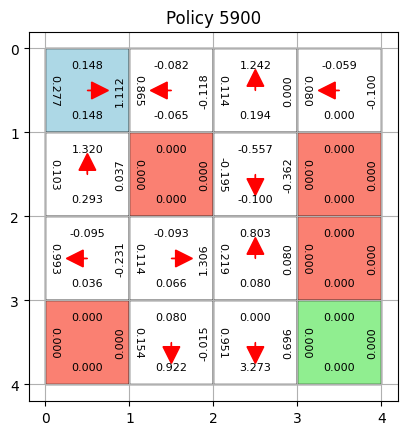

Updated policy 5950 [3 3 0 2 0 0 1 0 3 1 0 0 0 2 1 0] 
 [[3 3 0 2]
 [0 0 1 0]
 [3 1 0 0]
 [0 2 1 0]]


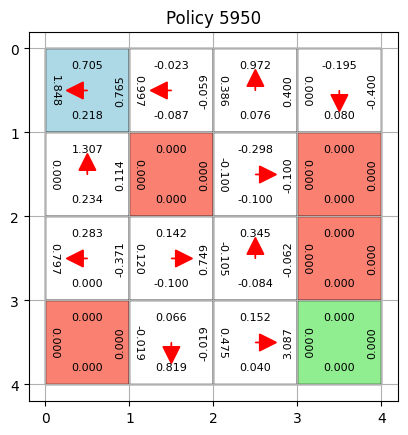

Current epsilon value - 0.26279012190489515
Updated policy 6000 [1 3 0 3 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[1 3 0 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


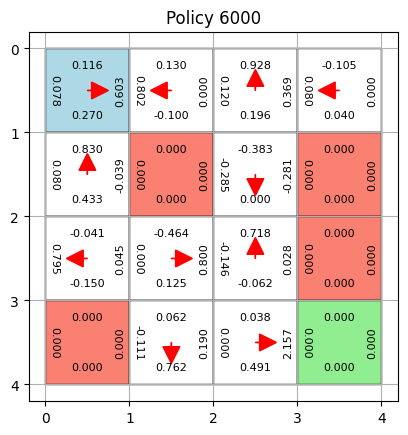

Updated policy 6050 [3 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


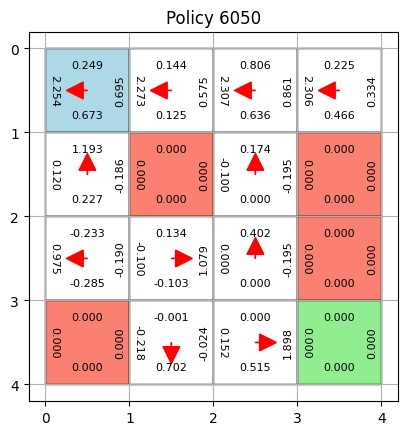

Updated policy 6100 [3 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


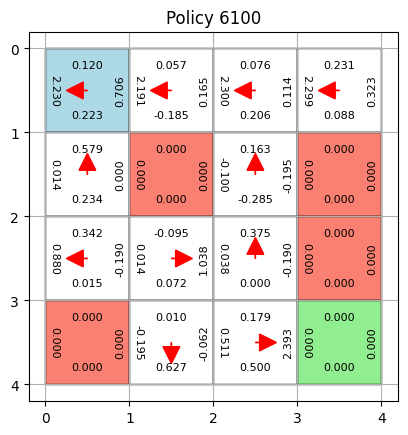

Updated policy 6150 [3 3 3 3 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


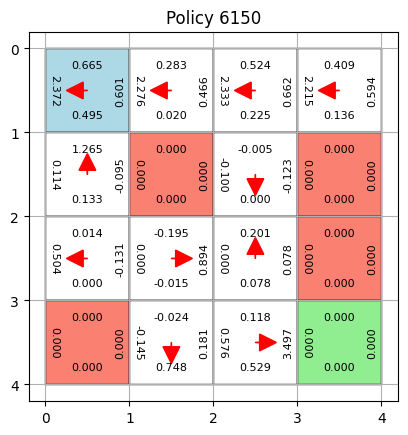

Updated policy 6200 [3 3 3 3 0 0 1 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 1 0]
 [3 1 0 0]
 [0 2 1 0]]


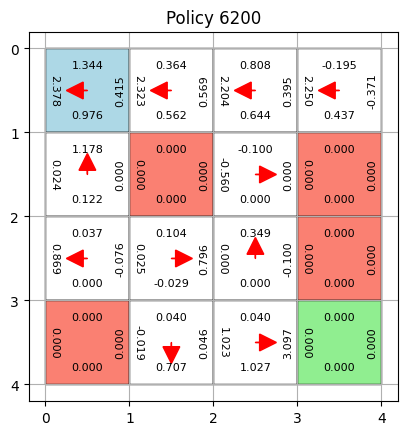

Current epsilon value - 0.24965061580965037
Updated policy 6250 [1 3 1 3 0 0 1 0 3 1 0 0 0 2 1 0] 
 [[1 3 1 3]
 [0 0 1 0]
 [3 1 0 0]
 [0 2 1 0]]


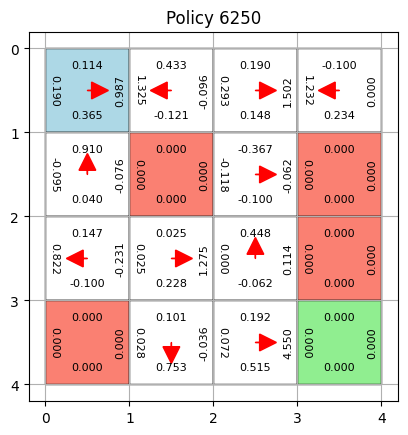

Updated policy 6300 [3 3 3 3 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


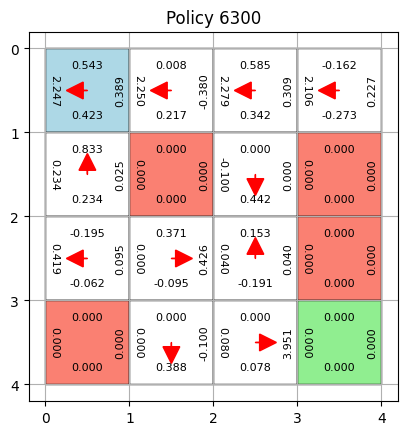

Updated policy 6350 [3 3 3 3 0 0 2 0 3 1 0 0 0 2 2 0] 
 [[3 3 3 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 2 0]]


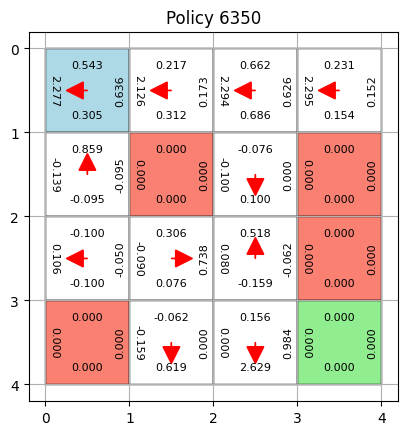

Updated policy 6400 [3 3 3 3 0 0 2 0 3 1 0 0 0 2 2 0] 
 [[3 3 3 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 2 0]]


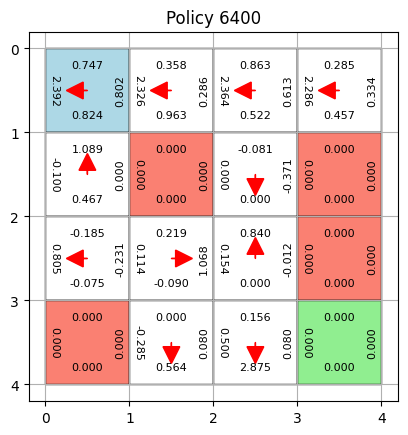

Updated policy 6450 [3 3 3 3 0 0 3 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 3 0]
 [3 1 0 0]
 [0 2 1 0]]


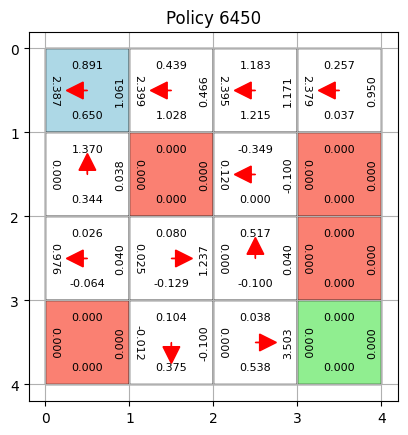

Current epsilon value - 0.23716808501916783
Updated policy 6500 [3 3 3 3 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


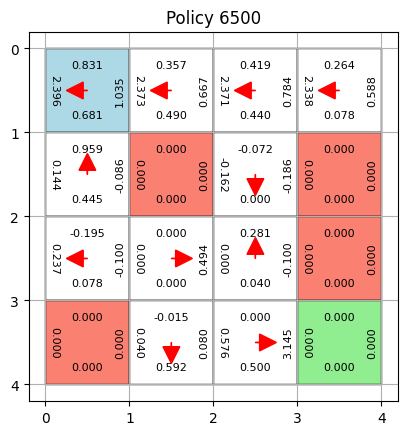

Updated policy 6550 [3 3 3 3 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


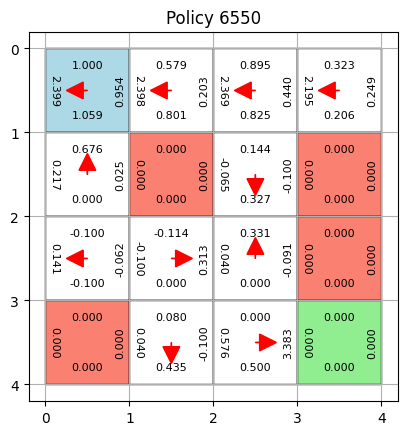

Updated policy 6600 [3 3 3 3 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


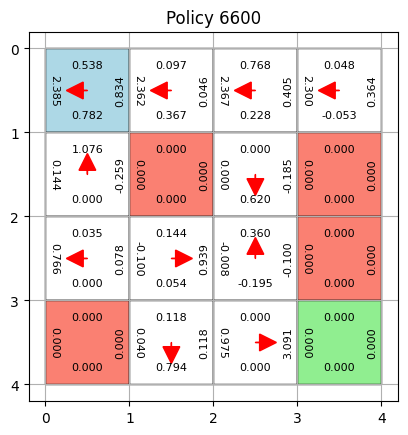

Updated policy 6650 [3 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


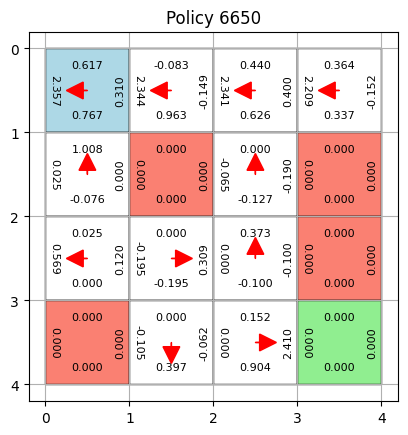

Updated policy 6700 [3 3 3 3 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


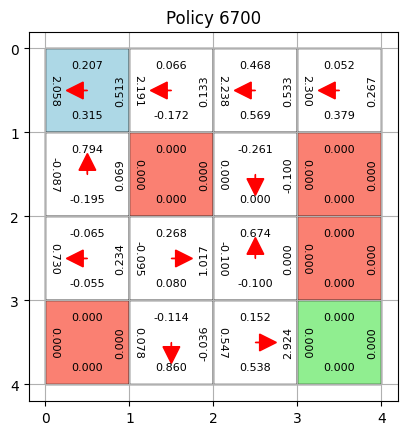

Current epsilon value - 0.22530968076820942
Updated policy 6750 [3 3 3 3 0 0 3 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 3 0]
 [3 1 0 0]
 [0 2 1 0]]


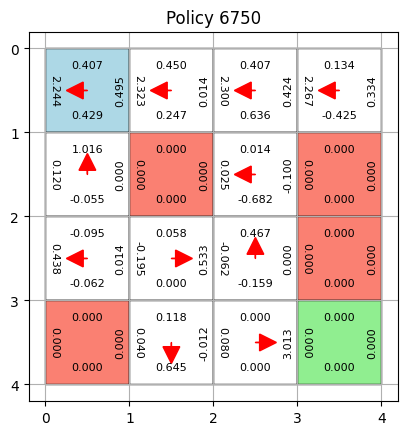

Updated policy 6800 [3 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


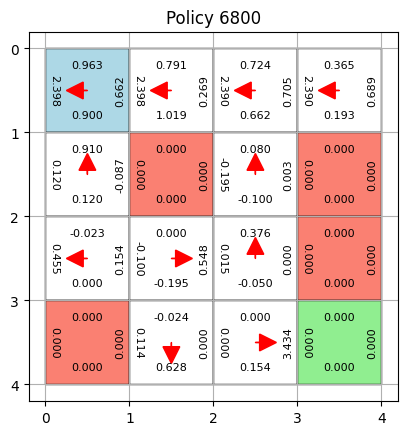

Updated policy 6850 [3 3 3 3 0 0 1 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 1 0]
 [3 1 0 0]
 [0 2 1 0]]


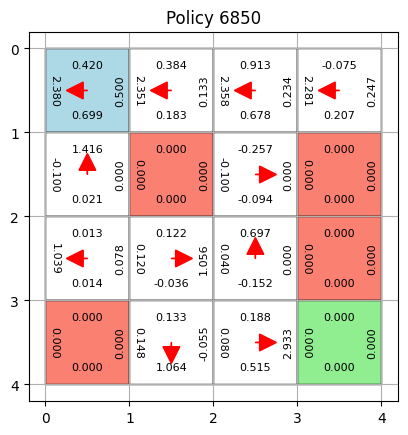

Updated policy 6900 [3 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


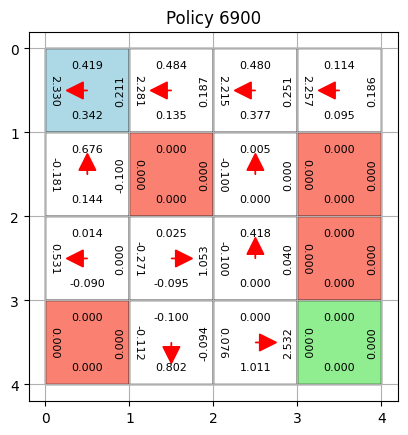

Updated policy 6950 [3 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


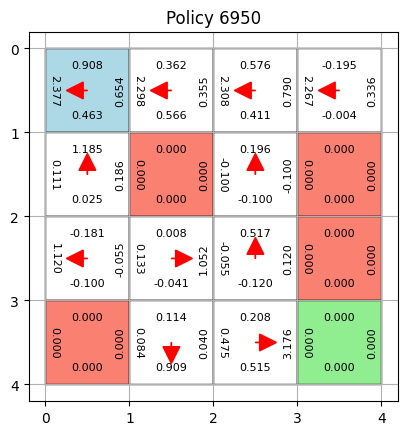

Current epsilon value - 0.21404419672979894
Updated policy 7000 [3 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


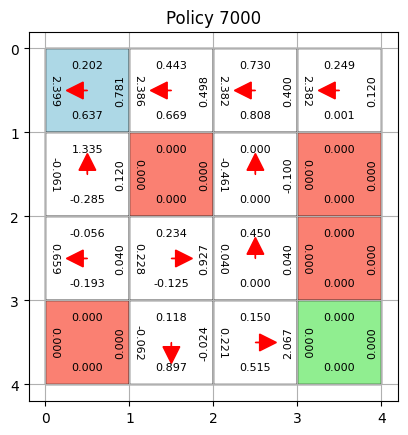

Updated policy 7050 [3 3 3 3 0 0 3 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 3 0]
 [3 1 0 0]
 [0 2 1 0]]


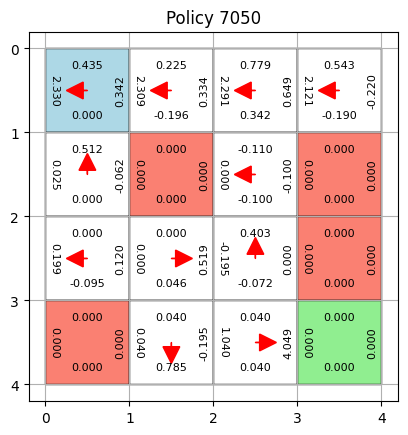

Updated policy 7100 [0 0 0 2 0 0 1 0 3 1 0 0 0 2 1 0] 
 [[0 0 0 2]
 [0 0 1 0]
 [3 1 0 0]
 [0 2 1 0]]


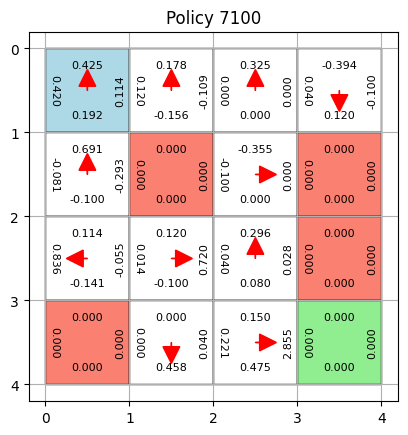

Updated policy 7150 [3 2 3 3 0 0 0 0 3 1 0 0 0 2 1 0] 
 [[3 2 3 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


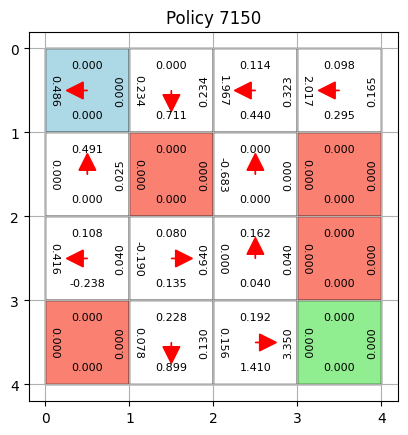

Updated policy 7200 [2 3 3 3 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[2 3 3 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


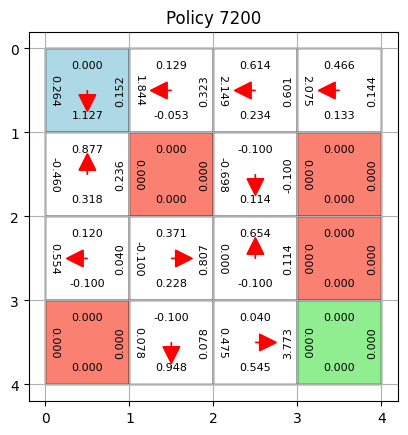

Current epsilon value - 0.20334198689330898
Updated policy 7250 [1 3 3 3 0 0 3 0 3 1 0 0 0 2 1 0] 
 [[1 3 3 3]
 [0 0 3 0]
 [3 1 0 0]
 [0 2 1 0]]


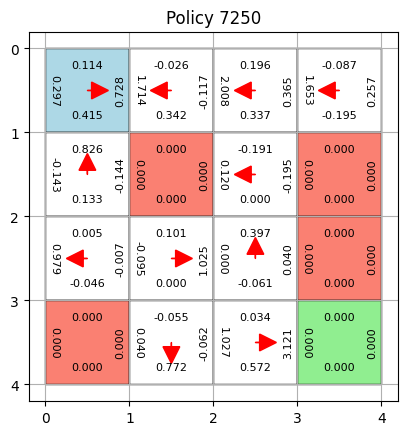

Updated policy 7300 [3 2 0 1 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[3 2 0 1]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


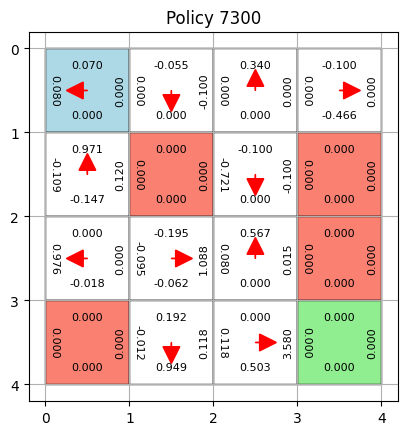

Updated policy 7350 [2 3 0 1 0 0 0 0 3 1 0 0 0 2 1 0] 
 [[2 3 0 1]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


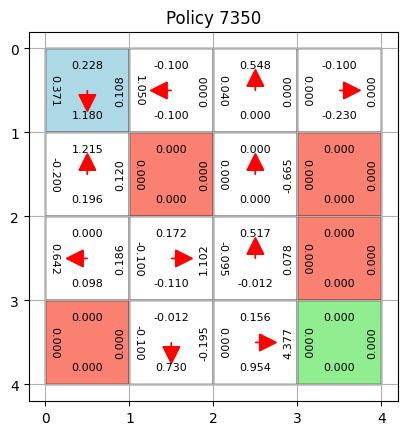

Updated policy 7400 [1 3 1 3 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[1 3 1 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


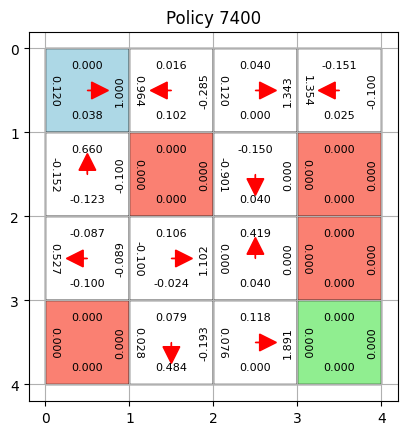

Updated policy 7450 [1 3 1 3 0 0 3 0 3 1 0 0 0 2 1 0] 
 [[1 3 1 3]
 [0 0 3 0]
 [3 1 0 0]
 [0 2 1 0]]


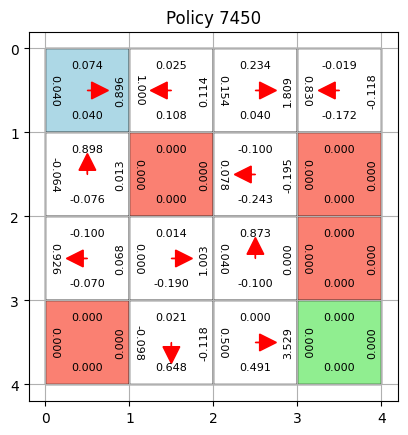

Current epsilon value - 0.19317488754864354
Updated policy 7500 [3 3 1 3 0 0 0 0 3 1 0 0 0 2 1 0] 
 [[3 3 1 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


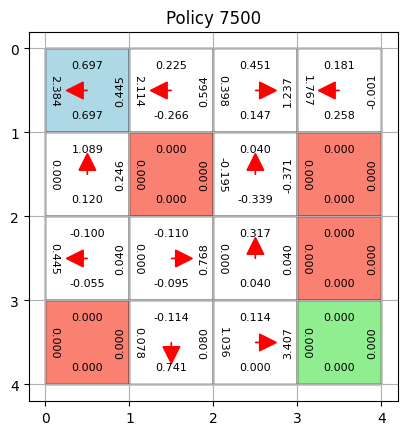

Updated policy 7550 [1 3 0 0 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[1 3 0 0]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


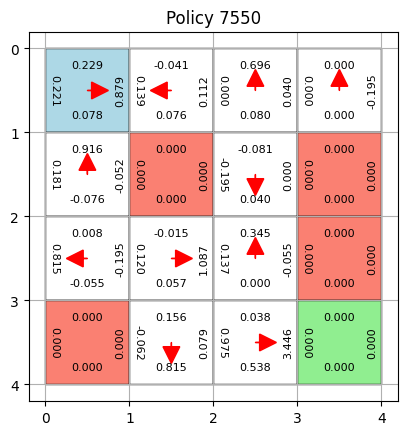

Updated policy 7600 [3 3 2 3 0 0 1 0 3 1 0 0 0 2 1 0] 
 [[3 3 2 3]
 [0 0 1 0]
 [3 1 0 0]
 [0 2 1 0]]


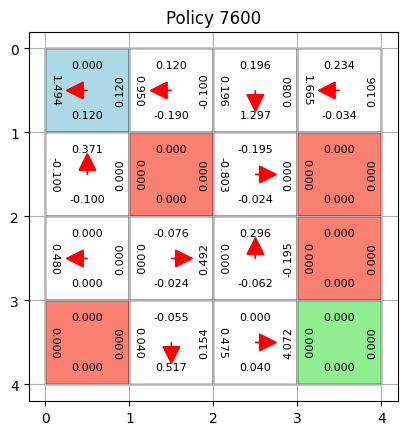

Updated policy 7650 [1 3 2 3 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[1 3 2 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


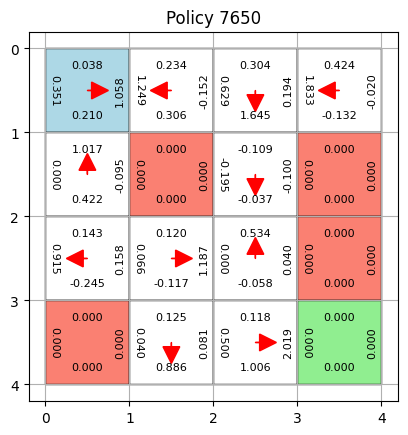

Updated policy 7700 [1 3 1 3 0 0 3 0 3 1 0 0 0 2 1 0] 
 [[1 3 1 3]
 [0 0 3 0]
 [3 1 0 0]
 [0 2 1 0]]


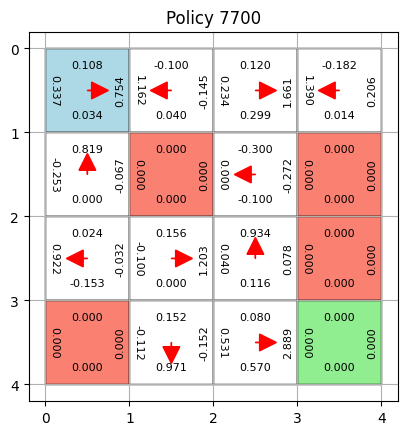

Current epsilon value - 0.18351614317121134
Updated policy 7750 [3 3 1 3 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[3 3 1 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


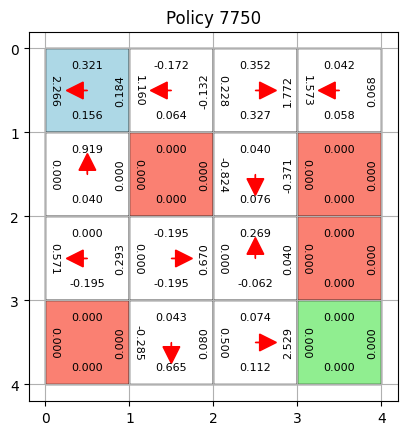

Updated policy 7800 [3 3 0 3 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[3 3 0 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


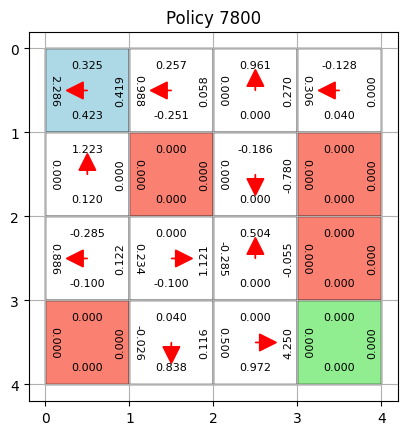

Updated policy 7850 [0 1 0 0 0 0 0 0 3 1 0 0 0 2 1 0] 
 [[0 1 0 0]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


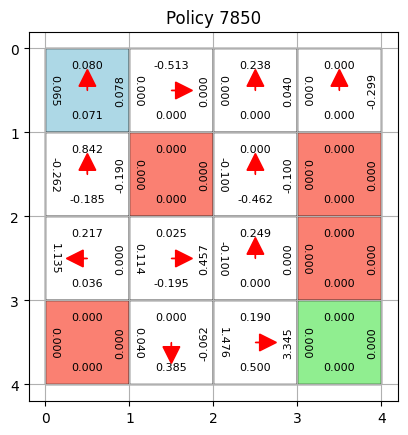

Updated policy 7900 [2 3 0 1 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[2 3 0 1]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


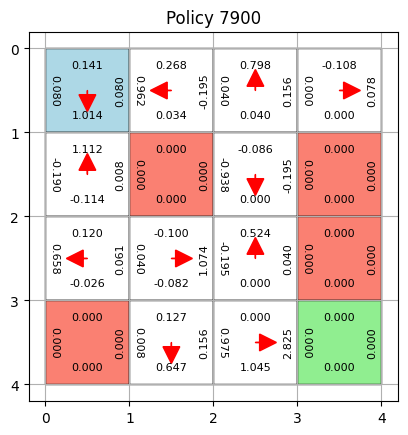

Updated policy 7950 [3 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


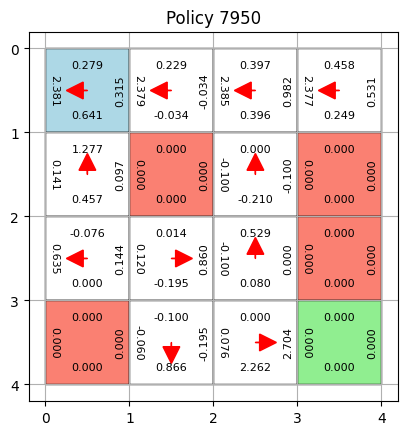

Current epsilon value - 0.17434033601265078
Updated policy 8000 [3 3 3 3 0 0 1 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 1 0]
 [3 1 0 0]
 [0 2 1 0]]


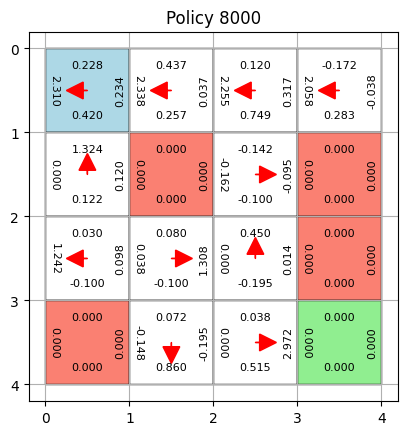

Updated policy 8050 [3 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0] 
 [[3 3 3 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


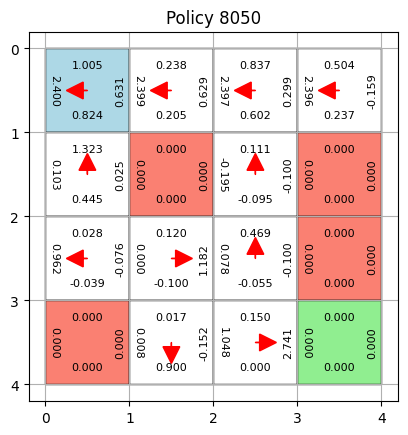

Updated policy 8100 [0 0 0 0 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[0 0 0 0]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


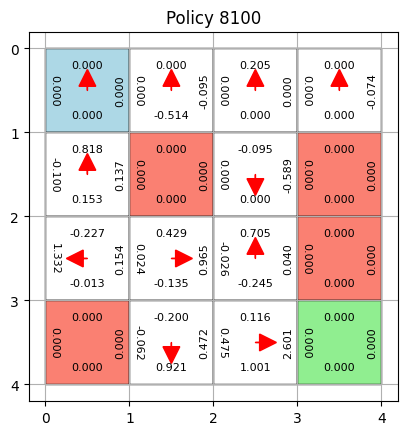

Updated policy 8150 [0 0 0 0 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[0 0 0 0]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


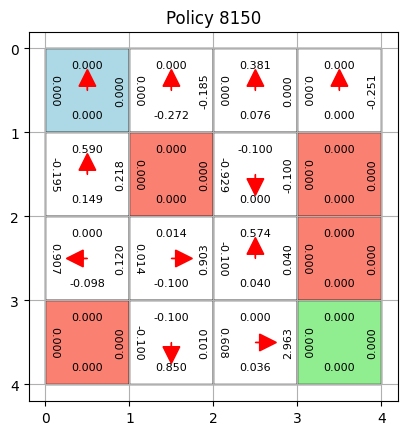

Updated policy 8200 [1 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0] 
 [[1 3 3 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


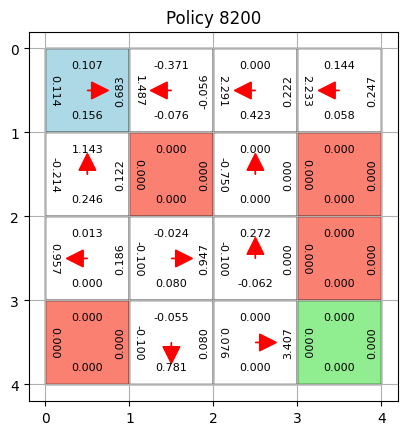

Current epsilon value - 0.16562331921201823
Updated policy 8250 [1 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0] 
 [[1 3 3 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


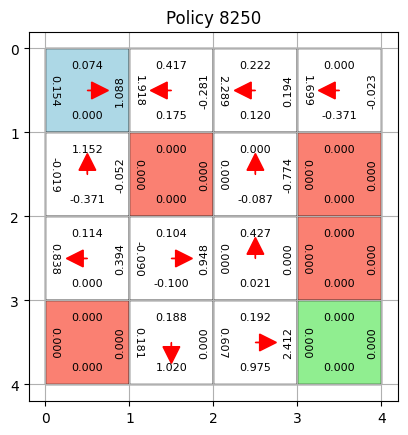

Updated policy 8300 [1 3 3 3 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[1 3 3 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


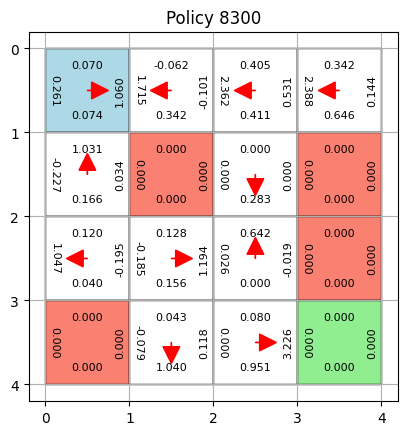

Updated policy 8350 [1 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0] 
 [[1 3 3 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


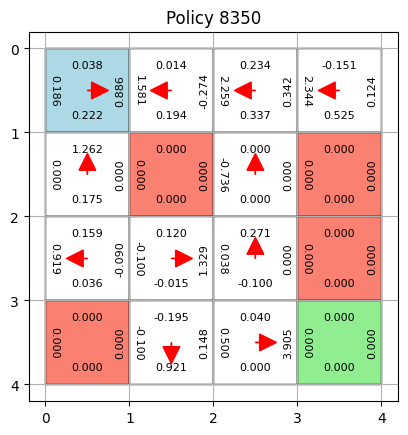

Updated policy 8400 [2 3 0 1 0 0 0 0 3 1 0 0 0 2 1 0] 
 [[2 3 0 1]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


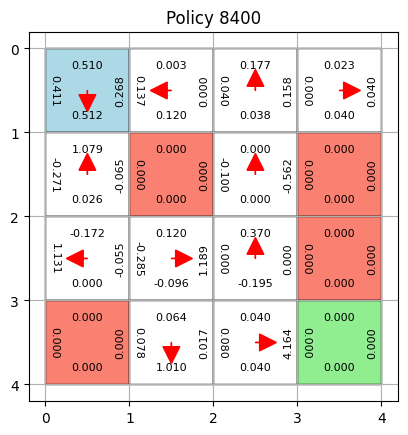

Updated policy 8450 [0 0 0 0 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[0 0 0 0]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


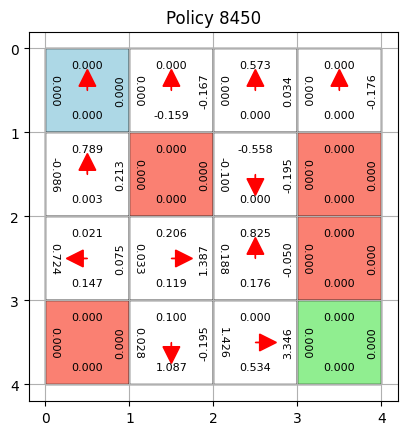

Current epsilon value - 0.15734215325141732
Updated policy 8500 [1 3 0 3 0 0 0 0 3 1 0 0 0 2 1 0] 
 [[1 3 0 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


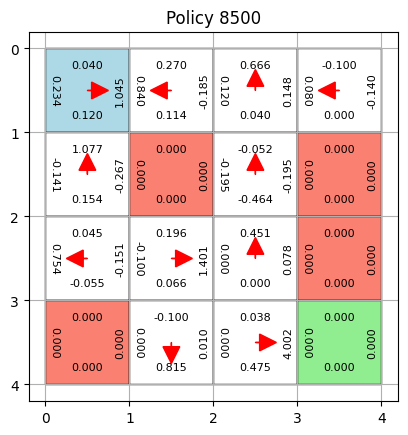

Updated policy 8550 [3 3 0 0 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[3 3 0 0]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


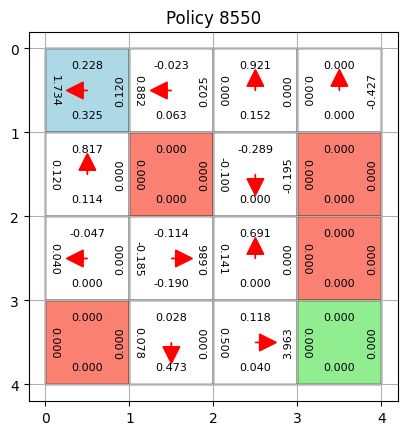

Updated policy 8600 [3 0 0 0 0 0 1 0 3 1 0 0 0 2 1 0] 
 [[3 0 0 0]
 [0 0 1 0]
 [3 1 0 0]
 [0 2 1 0]]


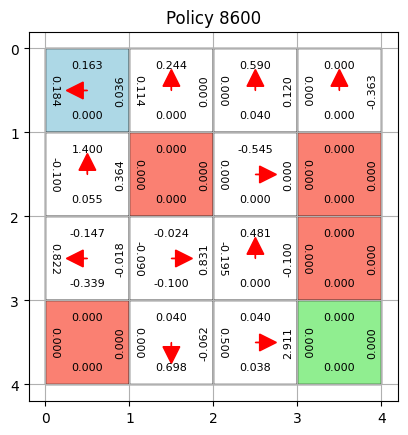

Updated policy 8650 [0 3 0 0 0 0 1 0 3 1 0 0 0 2 1 0] 
 [[0 3 0 0]
 [0 0 1 0]
 [3 1 0 0]
 [0 2 1 0]]


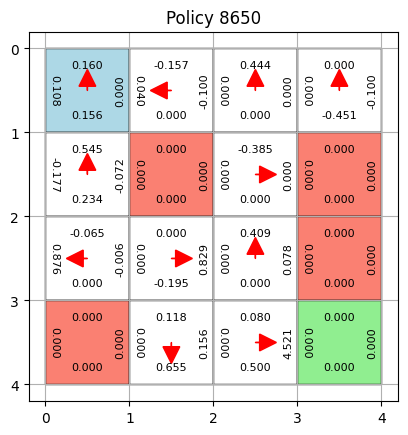

Updated policy 8700 [3 3 0 1 0 0 1 0 3 1 0 0 0 2 1 0] 
 [[3 3 0 1]
 [0 0 1 0]
 [3 1 0 0]
 [0 2 1 0]]


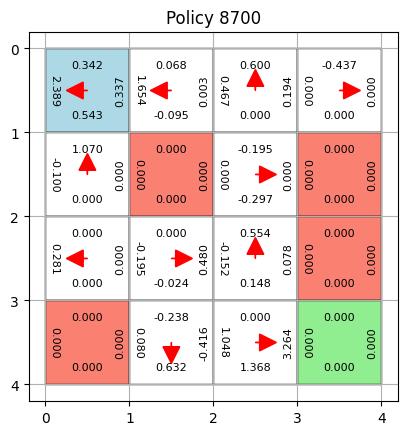

Current epsilon value - 0.14947504558884644
Updated policy 8750 [3 3 0 0 0 0 3 0 3 1 0 0 0 2 1 0] 
 [[3 3 0 0]
 [0 0 3 0]
 [3 1 0 0]
 [0 2 1 0]]


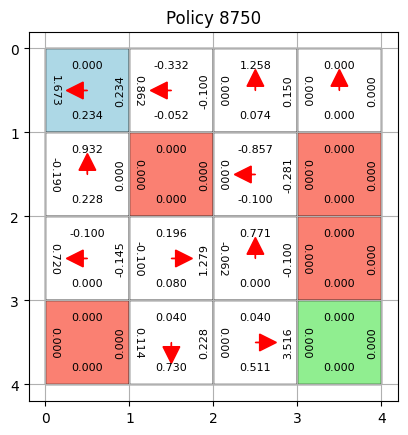

Updated policy 8800 [2 3 0 2 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[2 3 0 2]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


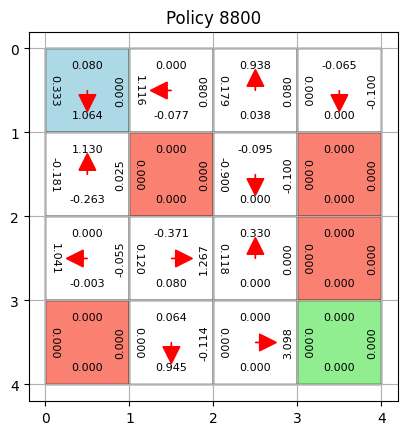

Updated policy 8850 [1 3 3 3 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[1 3 3 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


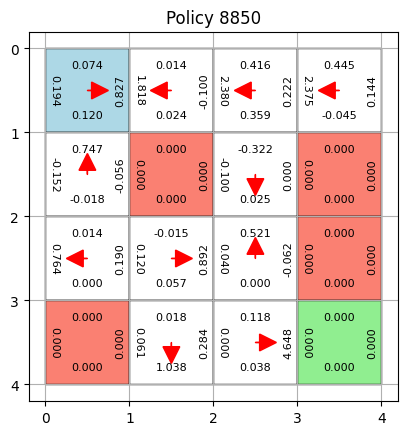

Updated policy 8900 [0 2 0 3 0 0 1 0 3 1 0 0 0 2 1 0] 
 [[0 2 0 3]
 [0 0 1 0]
 [3 1 0 0]
 [0 2 1 0]]


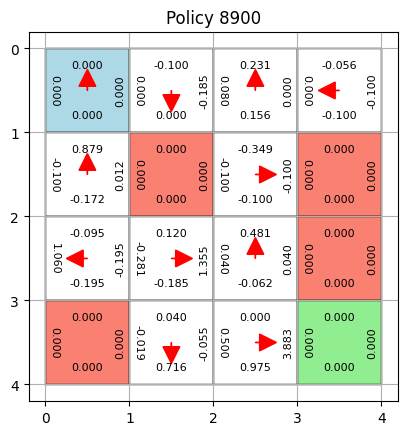

Updated policy 8950 [0 0 0 0 0 0 1 0 3 1 0 0 0 2 1 0] 
 [[0 0 0 0]
 [0 0 1 0]
 [3 1 0 0]
 [0 2 1 0]]


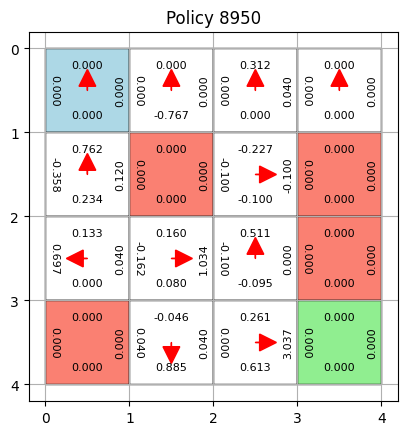

Current epsilon value - 0.14200129330940411
Updated policy 9000 [3 3 0 3 0 0 0 0 3 1 0 0 0 2 1 0] 
 [[3 3 0 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


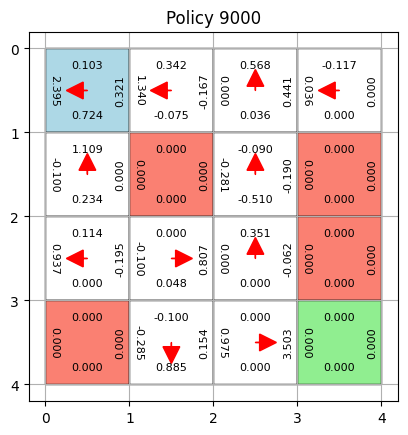

Updated policy 9050 [1 3 0 3 0 0 0 0 3 1 0 0 0 2 1 0] 
 [[1 3 0 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


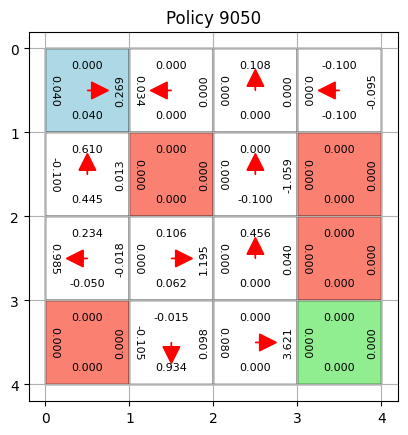

Updated policy 9100 [2 1 0 1 0 0 1 0 0 1 0 0 0 2 1 0] 
 [[2 1 0 1]
 [0 0 1 0]
 [0 1 0 0]
 [0 2 1 0]]


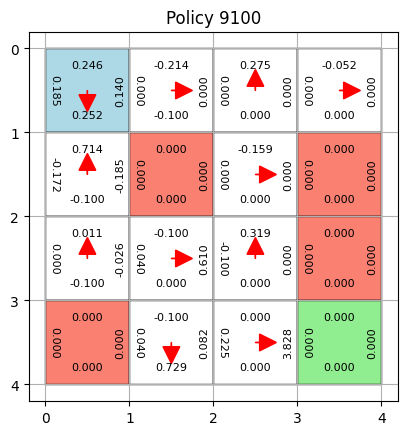

Updated policy 9150 [3 3 0 2 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[3 3 0 2]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


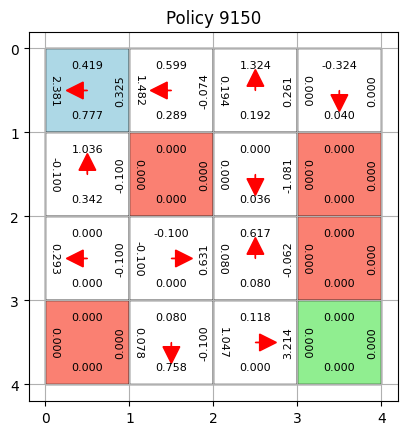

Updated policy 9200 [0 0 0 1 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[0 0 0 1]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


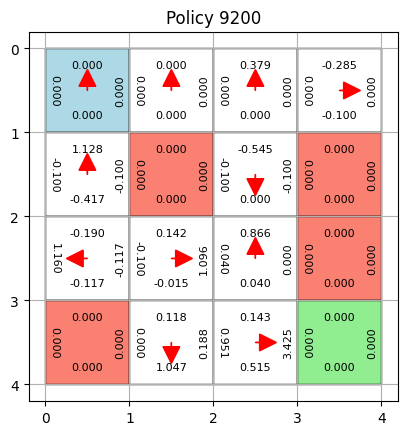

Current epsilon value - 0.1349012286439339
Updated policy 9250 [0 0 0 1 0 0 1 0 3 1 0 0 0 2 1 0] 
 [[0 0 0 1]
 [0 0 1 0]
 [3 1 0 0]
 [0 2 1 0]]


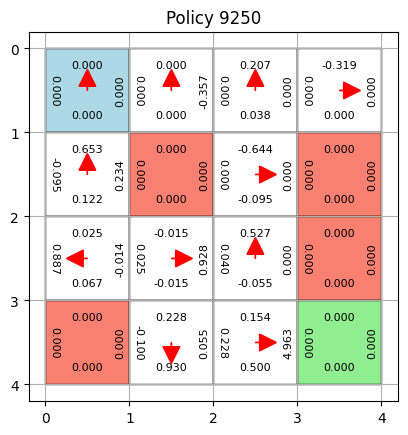

Updated policy 9300 [0 0 0 1 0 0 0 0 3 1 0 0 0 2 1 0] 
 [[0 0 0 1]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


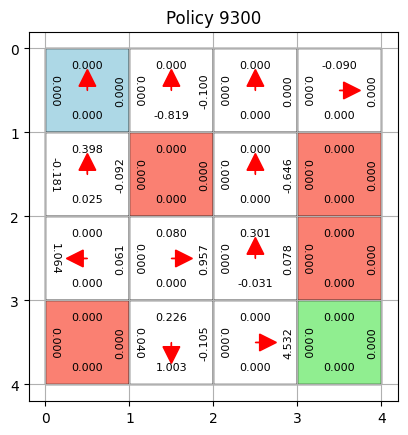

Updated policy 9350 [3 3 0 1 0 0 1 0 3 1 0 0 0 2 1 0] 
 [[3 3 0 1]
 [0 0 1 0]
 [3 1 0 0]
 [0 2 1 0]]


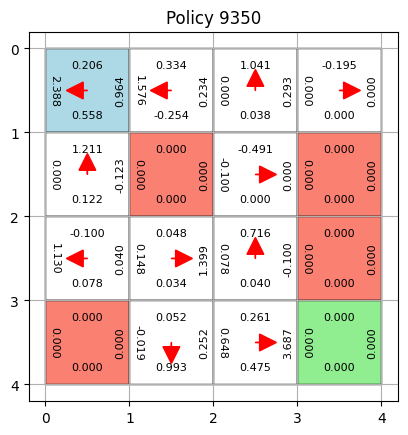

Updated policy 9400 [1 3 0 1 0 0 3 0 3 1 0 0 0 2 1 0] 
 [[1 3 0 1]
 [0 0 3 0]
 [3 1 0 0]
 [0 2 1 0]]


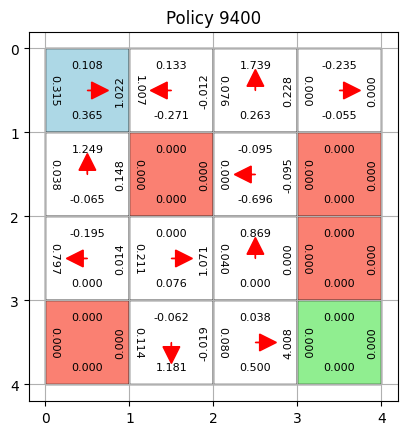

Updated policy 9450 [0 0 0 3 0 0 0 0 3 1 0 0 0 2 1 0] 
 [[0 0 0 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


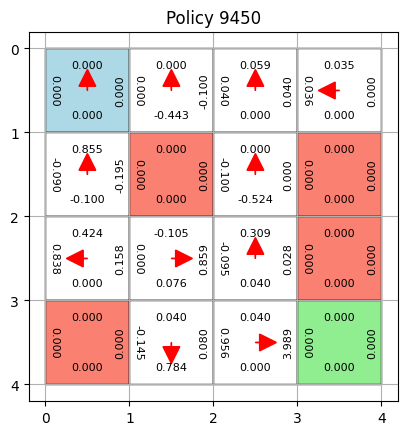

Current epsilon value - 0.1281561672117372
Updated policy 9500 [1 3 0 2 0 0 1 0 3 1 0 0 0 2 1 0] 
 [[1 3 0 2]
 [0 0 1 0]
 [3 1 0 0]
 [0 2 1 0]]


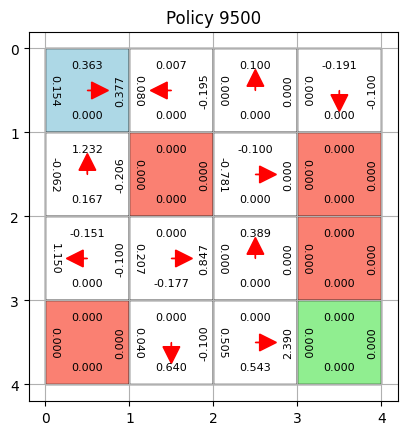

Updated policy 9550 [2 3 0 0 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[2 3 0 0]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


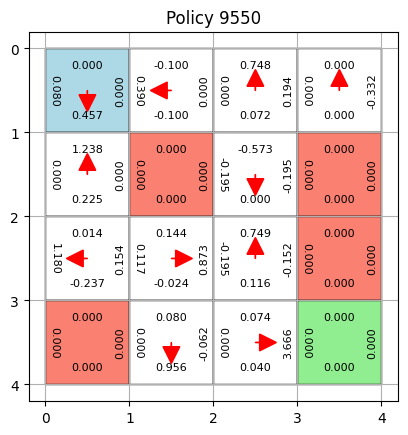

Updated policy 9600 [1 3 0 1 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[1 3 0 1]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


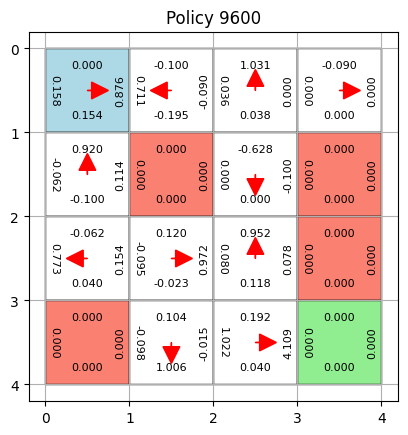

Updated policy 9650 [3 3 0 3 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[3 3 0 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


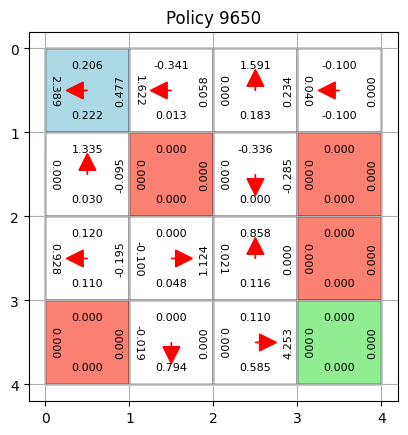

Updated policy 9700 [3 3 2 3 0 0 0 0 3 1 0 0 0 2 1 0] 
 [[3 3 2 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


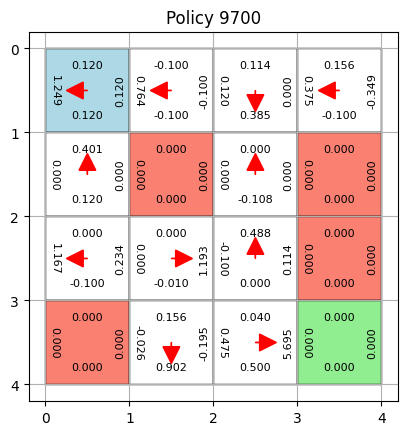

Current epsilon value - 0.12174835885115033
Updated policy 9750 [0 0 0 2 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[0 0 0 2]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


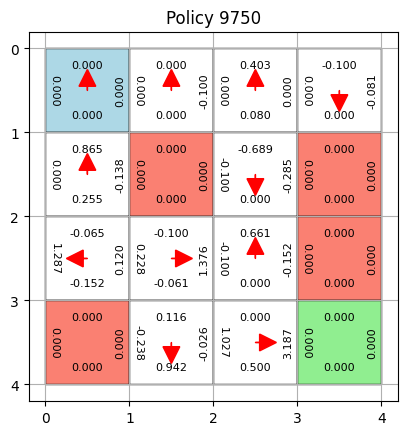

Updated policy 9800 [3 3 1 3 0 0 0 0 3 1 0 0 0 2 1 0] 
 [[3 3 1 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


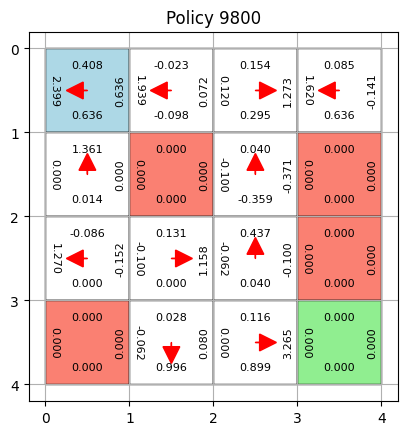

Updated policy 9850 [1 2 3 0 0 0 0 0 3 1 0 0 0 2 1 0] 
 [[1 2 3 0]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


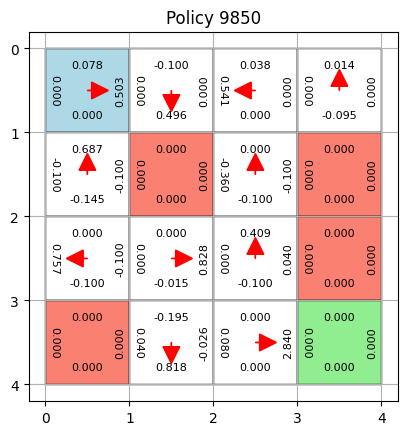

Updated policy 9900 [2 3 0 1 0 0 0 0 3 1 0 0 0 2 1 0] 
 [[2 3 0 1]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


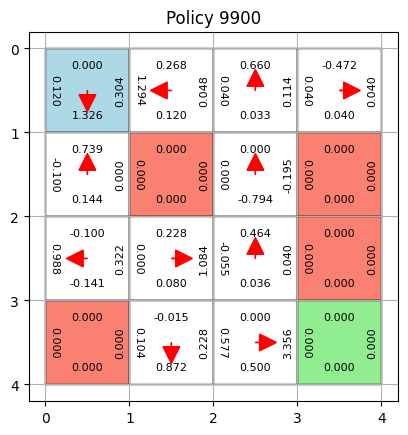

Updated policy 9950 [0 3 0 0 0 0 0 0 3 1 0 0 0 2 1 0] 
 [[0 3 0 0]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


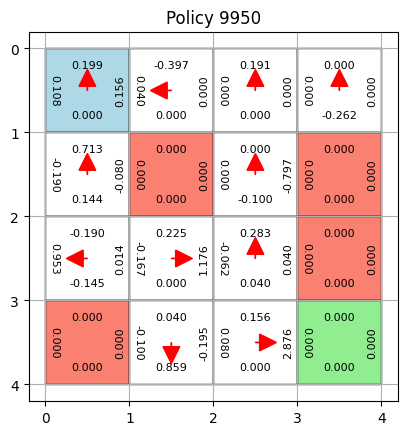

Updated policy 9999 [0 0 0 0 0 0 2 0 3 1 0 0 0 2 1 0] 
 [[0 0 0 0]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


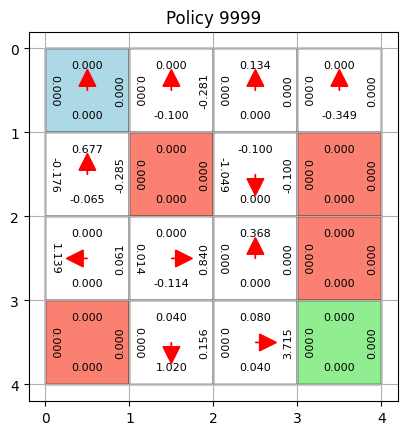

In [87]:
# policy = np.random.choice(size = env.observation_space.n, a = np.arange(0,4,1))
policy = np.zeros(16, dtype=int)

gamma = 0.8                 # discount factor in calculating the return at each step
epsilon = 0.9               # probability of exploratory moves in epsilon-greedy
alpha = 0.05

n_policy_eval = 50          # number of trajectories considered when evaluating the policy
n_policy_updates = 10000    # number of policy improvement iterations
n_episodes_test = 50        # number of simulated episode to assess the performance of a trained policy (one test every x amount of policy improvement)

eps_decay = 0.95
eps_decay_rate = 250

all_policies = []
count = 0

policy, policy_history, state_action_values, success_rates, step_average_per_eps_list = TD_policy_improvement(policy, n_policy_eval, n_policy_updates, n_episodes_test,
                                                                                                              gamma, epsilon, eps_decay, eps_decay_rate, alpha)

In [96]:
for idx, item in enumerate(zip(success_rates, step_average_per_eps_list)):
    print(f"At policy {idx*50:4d} - Success rate of {item[0]:5.2f}% and takes {item[1]:3.0f} steps")

At policy    0 - Success rate of 12.00% and takes  16 steps
At policy   50 - Success rate of  0.00% and takes   0 steps
At policy  100 - Success rate of 32.00% and takes  35 steps
At policy  150 - Success rate of 14.00% and takes  13 steps
At policy  200 - Success rate of  0.00% and takes   0 steps
At policy  250 - Success rate of 10.00% and takes  15 steps
At policy  300 - Success rate of 10.00% and takes  17 steps
At policy  350 - Success rate of  2.00% and takes   9 steps
At policy  400 - Success rate of 22.00% and takes  31 steps
At policy  450 - Success rate of 10.00% and takes  14 steps
At policy  500 - Success rate of 12.00% and takes  18 steps
At policy  550 - Success rate of 10.00% and takes  20 steps
At policy  600 - Success rate of  2.00% and takes  13 steps
At policy  650 - Success rate of  8.00% and takes  18 steps
At policy  700 - Success rate of  4.00% and takes  18 steps
At policy  750 - Success rate of  6.00% and takes  27 steps
At policy  800 - Success rate of  0.00% 

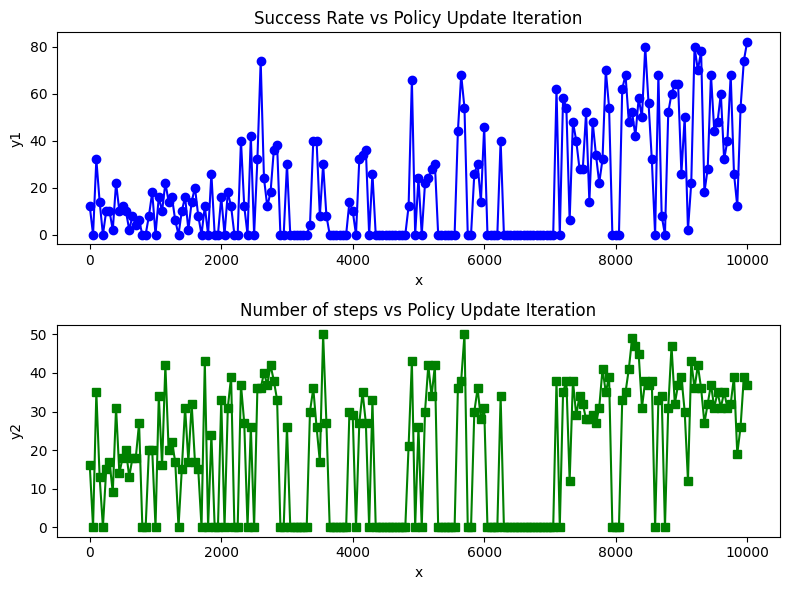

In [97]:
# Visualize the history of success rate
import matplotlib.pyplot as plt

iter = np.zeros(len(success_rates))
success_rate_list = np.zeros(len(success_rates))
step_count_list = np.zeros(len(step_average_per_eps_list))


for idx, item in enumerate(zip(success_rates, step_average_per_eps_list)):
    iter[idx] = idx * 50
    success_rate_list[idx] = item[0]
    step_count_list[idx] = item[1]

# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))  # 2 rows, 1 column

# Plot y1 vs x on the first subplot
ax1.plot(iter, success_rate_list, marker='o', color='blue')
ax1.set_title('Success Rate vs Policy Update Iteration')
ax1.set_xlabel('x')
ax1.set_ylabel('y1')

# Plot y2 vs x on the second subplot
ax2.plot(iter, step_count_list, marker='s', color='green')
ax2.set_title('Number of steps vs Policy Update Iteration')
ax2.set_xlabel('x')
ax2.set_ylabel('y2')

# Adjust layout
plt.tight_layout()
plt.show()

In [90]:
len(policy_history)

201

Test out the policy above in a simulation

In [94]:
env_test = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True, render_mode = "ansi")  # is_slippery=True for stochasticity
env_test.reset()

success_count = 0           # Number of successful episode
step_count = 0              # Number of steps in a successful episode
n_episodes_test = 5000

# Benchmark against a random deterministic policy
random_policy = np.random.choice(size = env.observation_space.n, a = np.arange(0,4,1))


for i in range(n_episodes_test):

    env_test.reset()
    state = 0; t = 0
    stochastic_policy = deterministic_to_stochastic_policy(policy_history[185], epsilon=0)

    term = False; trunc = False
    states = []; states.append(state)
    actions = []

    while (not term) and (not trunc):
        
        action = np.random.choice(a = env_test.action_space.n, 
                                p = stochastic_policy[:,state])
        next_state, reward, term, trunc, info = env_test.step(action)
        # print(f"Time {t:2d}  |  s_t {state:3d}  |  a_t {action:2d}  |  s_t+1 {next_state:3d}  |  reward {reward:.2f}  |  terminated {term:2}  |  {info}")
        # print(env.render())

        states.append(next_state)
        actions.append(action)

        state = next_state; t += 1

        if next_state == 15: 
            success_count += 1 
            step_count += len(states)

success_rate = success_count / n_episodes_test * 100
step_average_per_eps = np.round(step_count / (success_count+0.0001))
print(f"Success rate of {success_rate:.5f}% \n Average number of step required - {step_average_per_eps:3f}")

Success rate of 65.80000% 
 Average number of step required - 37.000000


Visualize the state-action values on a 3D grid

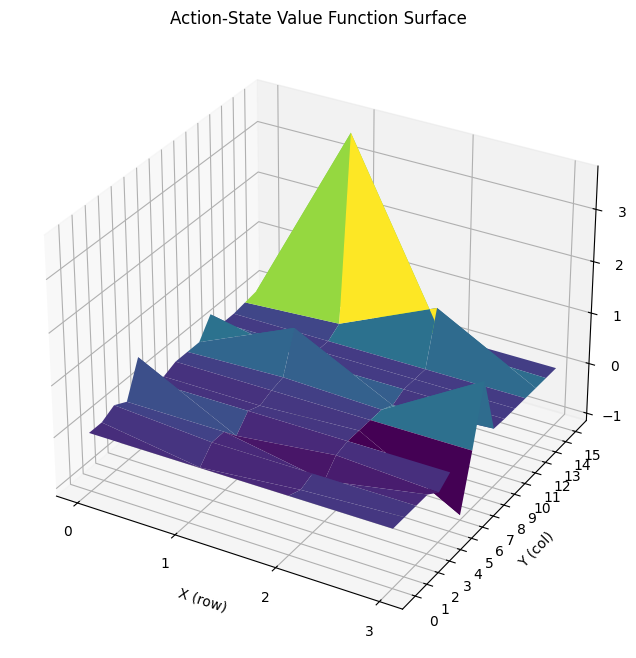

In [95]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib widget

actions = np.arange(state_action_values.shape[0])
states = np.arange(state_action_values.shape[1])

A, S = np.meshgrid(actions,states)
Q = state_action_values[A,S]

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(A, S, Q, cmap='viridis')
ax.set_xlabel('X (row)')
ax.set_ylabel('Y (col)')
ax.set_zlabel('Value V(s)')
ax.set_xticks(actions)
ax.set_yticks(states)


plt.title("Action-State Value Function Surface")
plt.show()

# TD($\lambda$) Learning